In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import time
import math
import seaborn as sns

from src.mazeworld import WallAutoCollectMazeWorld, WallCollectMazeWorld, LimitedCollectWallMazeWorld
from src.mdp import MDP, LegibleTaskMDP, LearnerMDP
from tqdm import tqdm
from itertools import combinations
%matplotlib notebook

In [2]:
def get_goal_states(states, goal):

    state_lst = list(states)
    return [state_lst.index(x) for x in states if x.find(goal) != -1]

def get_initial_states(states, task_locs):

    return [state for state in states if state.find('N') != -1] + \
           [str(e[0]) + ' ' + str(e[1]) + ' ' + e[2] for e in task_locs]

def simulate(mdp, pol, mdp_tasks, leg_pol, x0, n_trajs, goal):

    mdp_trajs = []
    tasks_trajs = []

    for _ in tqdm(range(n_trajs), desc='Simulate Trajectories'):
        traj, acts = mdp.trajectory(x0, pol)
        traj_leg, acts_leg = mdp_tasks.trajectory(x0, leg_pol)
        mdp_trajs += [[traj, acts]]
        tasks_trajs += [[traj_leg, acts_leg]]

    mdp_r = mdp.trajectory_reward(mdp_trajs)
    mdp_rl = mdp_tasks.trajectory_reward(goal, mdp_trajs)
    task_r = mdp.trajectory_reward(tasks_trajs)
    task_rl = mdp_tasks.trajectory_reward(goal, tasks_trajs)

    return mdp_r, mdp_rl, task_r, task_rl

In [3]:
def create_world_view(n_rows, n_cols, obj_place, walls=None):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot()
    plt.xlim(0, n_cols)
    plt.ylim(0,  n_rows)
    plt.xticks([i+1 for i in range(n_cols)])
    plt.yticks([i+1 for i in range(n_rows)])
    plt.grid(True)

    for obj in obj_place:
        x = obj[1] - 0.5
        y = obj[0] - 0.5
        o = '$' + obj[2] + '$'
        
        plt.plot(x, y, marker=o, color='k', markersize=10)
    
    if walls:
        for wall in walls:
            wall_sec = np.array([list(wall_elem) for wall_elem in wall])
            plt.plot(wall_sec[:, 1] - 0.5, wall_sec[:, 0] - 0.5, color='k', linewidth=5)
    
    return fig, ax


def visualize_trajectory(x0, trajectory, figure, color):
    
    actions = {'U': (0, -0.8), 'D': (0, 0.8), 'L':(-0.8, 0), 'R':(0.8, 0), 'G': (0, 0), 'P':(0, 0), 'N': (0, 0)}
    ax = figure[1]
    
    plt.plot(x0[0]-0.5, x0[1]-0.5, marker='x', markersize=15, color='gold')
    for ptr in trajectory:
        x = ptr[0]-0.5
        y = ptr[1]-0.5
        a = actions[ptr[2]]
        if ptr[2] in ['U', 'D', 'L', 'R']:
            ax.arrow(x, y, a[0], a[1], head_width=0.1, head_length=0.1, lw=1.5, fc=color, ec=color)
        else:
            ax.add_patch(plt.Circle((x, y), 0.3, linewidth=1.7, fill=False, color=color))

def draw_policy_states(figure, pol, state_lst, action_lst, states, color):
    
    actions = {'U': (0, -0.8), 'D': (0, 0.8), 'L':(-0.8, 0), 'R':(0.8, 0), 'G': (0, 0), 'P':(0, 0), 'N': (0, 0)}
    ax = figure[1]
    
    for state in states:
        state_idx = state_lst.index(state)
        state_split = re.match(r"([0-9]+) ([0-9]+) ([a-z]+)", state, re.I)
        y = int(state_split.group(1)) - 0.5
        x = int(state_split.group(2)) - 0.5
        pol_actions = np.nonzero(pol[state_idx, :])[0]
        for action in pol_actions:
            act = action_lst[action]
            a = actions[act]
            if act in ['U', 'D', 'L', 'R']:
                ax.arrow(x, y, a[0], a[1], head_width=0.1, head_length=0.1, lw=1.5, fc=color, ec=color)
            else:
                ax.add_patch(plt.Circle((x, y), 0.3, linewidth=1.7, fill=False, color=color))
        
def process_trajectory(trajectory, actions):
    
    traj = []
    
    for i in range(len(trajectory) - 1):
        state_split = re.match(r"([0-9]+) ([0-9]+) ([a-z]+)", trajectory[i], re.I)
        y = int(state_split.group(1))
        x = int(state_split.group(2))
        o = state_split.group(3)
        
        traj += [(x, y, actions[i])]
    
    return traj

<IPython.core.display.Javascript object>


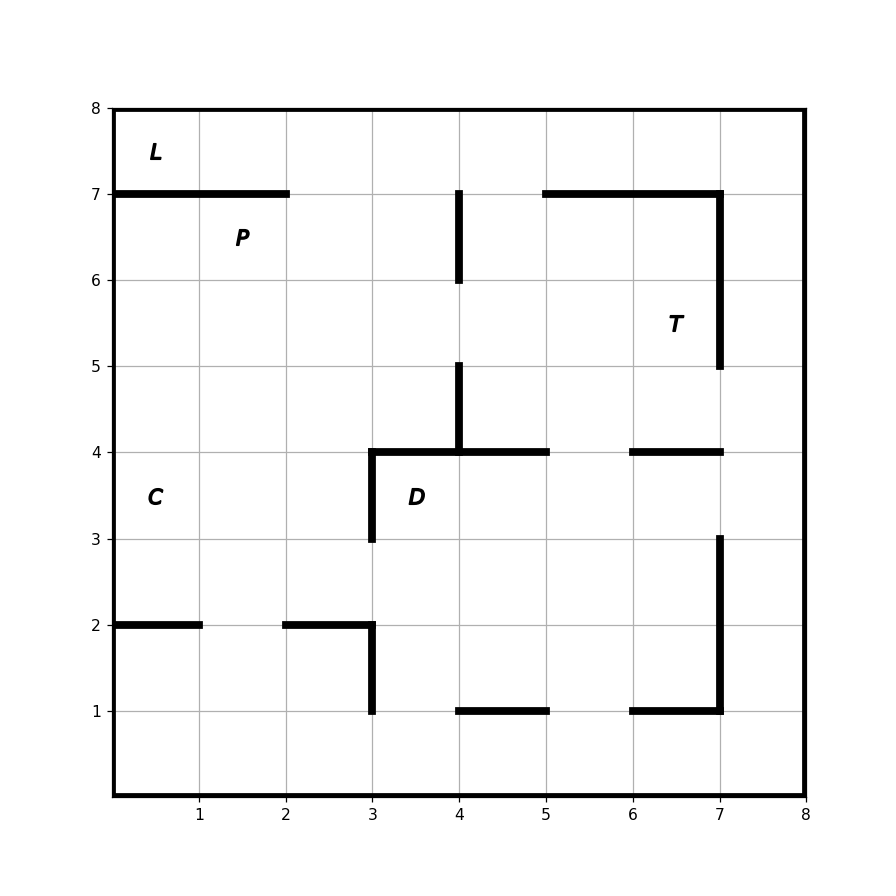

In [4]:
n_rows = 8
n_cols = 8
# objs_states = [(7, 2, 'P'), (4, 4, 'D'), (4, 1, 'C'), (8, 1, 'L'), (6, 7, 'T'), (8, 8, 'O')]
objs_states = [(7, 2, 'P'), (4, 4, 'D'), (4, 1, 'C'), (8, 1, 'L'), (6, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(1.5, 3.5), (2.5, 3.5)],
         [(3.5, 3.5), (4.5, 3.5)],
         [(2.5, 0.5), (2.5, 1.5)],
         [(2.5, 2.5), (2.5, 3.5)],
         [(1.5, x + 0.5) for x in range(4, 6)],
         [(1.5, 6.5), (1.5, 7.5)],
         [(7.5, x + 0.5) for x in range(0, 3)],
         [(7.5, x + 0.5) for x in range(5, 8)],
         [(x + 0.5, 4.5) for x in range(4, 6)],
         [(x + 0.5, 4.5) for x in range(6, 8)],
         [(4.5, x + 0.5) for x in range(3, 6)],
         [(4.5, x + 0.5) for x in range(6, 8)],
         [(x + 0.5, 7.5) for x in range(1, 4)],
         [(x + 0.5, 7.5) for x in range(5, 8)]]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'T'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


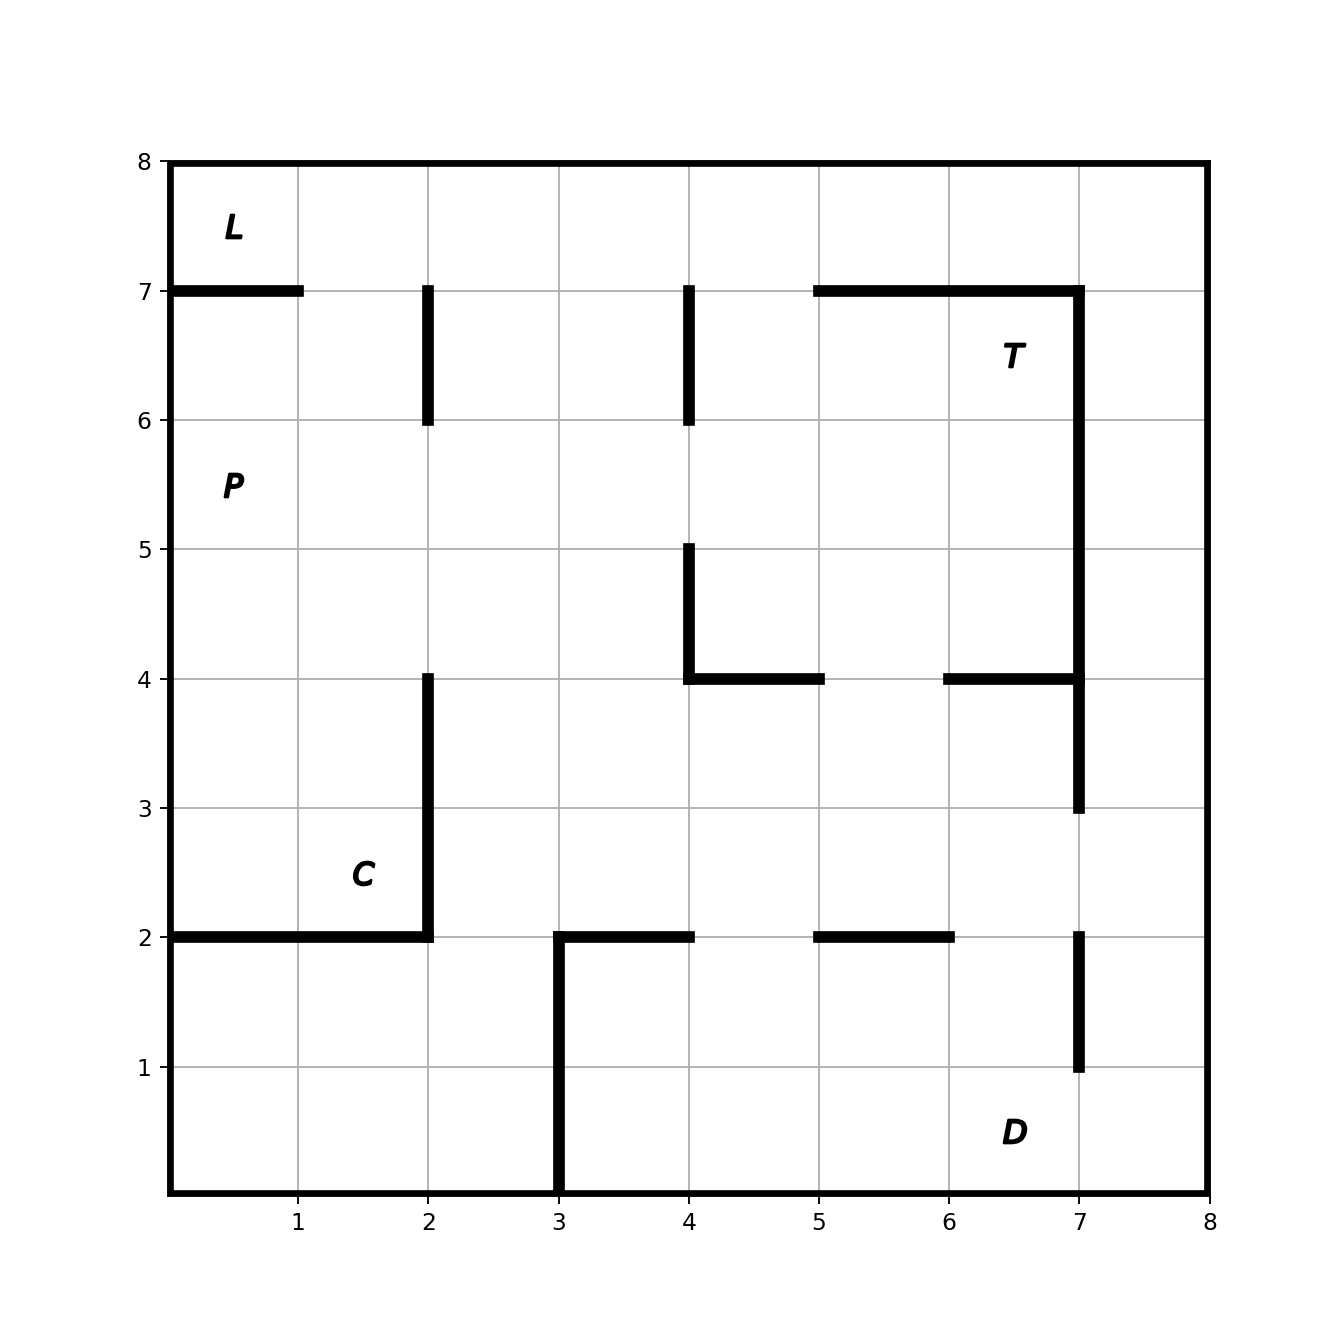

In [38]:
n_rows = 8
n_cols = 8
# objs_states = [(6, 1, 'P'), (1, 7, 'D'), (3, 2, 'C'), (8, 1, 'L'), (7, 7, 'T'), (8, 8, 'O')]
objs_states = [(6, 1, 'P'), (1, 7, 'D'), (3, 2, 'C'), (8, 1, 'L'), (7, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 3.5), (1.5, 3.5), (2.5, 3.5)],
         [(x + 0.5, 4.5) for x in range(4, 6)],
         [(x + 0.5, 4.5) for x in range(6, 8)],
         [(x + 0.5, 2.5) for x in range(2, 5)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 7.5) for x in range(1, 3)],
         [(x + 0.5, 7.5) for x in range(3, 8)],
         [(2.5, 0.5), (2.5, 1.5), (2.5, 2.5)],
         [(2.5, x + 0.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(5, 7)],
         [(7.5, x + 0.5) for x in range(0, 2)],
         [(7.5, x + 0.5) for x in range(5, 8)],
         [(4.5, x + 0.5) for x in range(4, 6)],
         [(4.5, x + 0.5) for x in range(6, 8)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'O'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


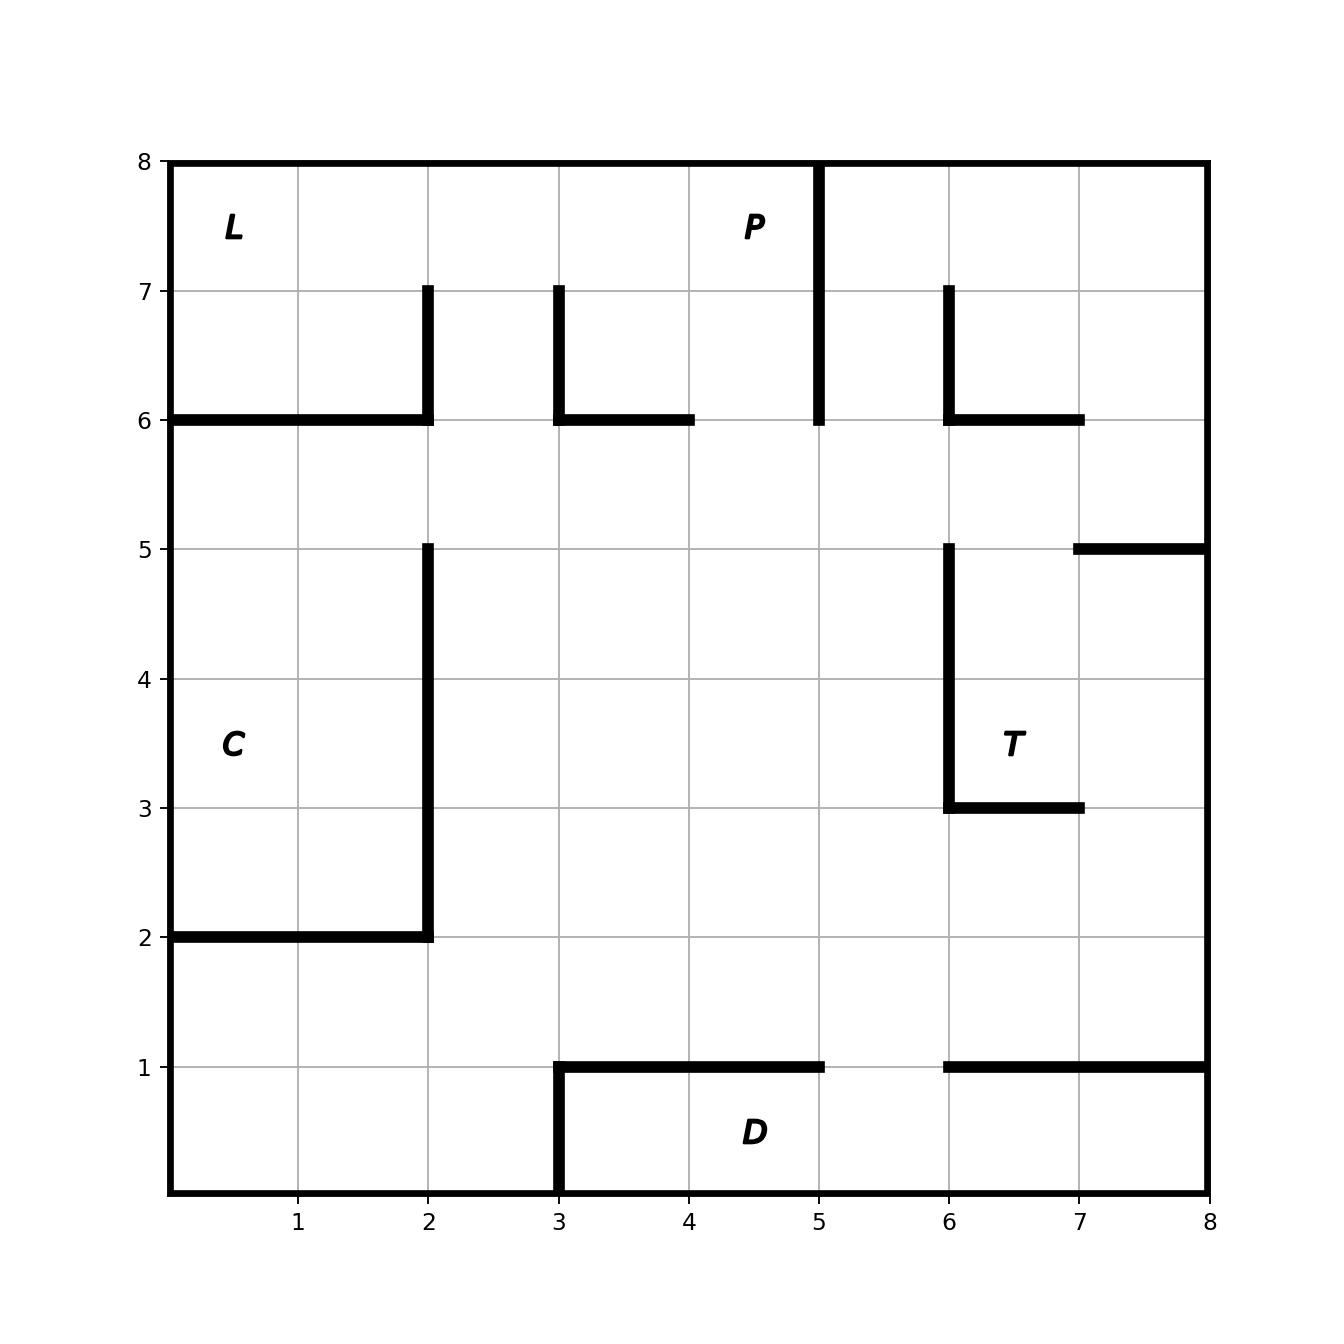

In [37]:
n_rows = 8
n_cols = 8
# objs_states = [(8, 5, 'P'), (1, 5, 'D'), (4, 1, 'C'), (8, 1, 'L'), (4, 7, 'T'), (8, 8, 'O')]
objs_states = [(8, 5, 'P'), (1, 5, 'D'), (4, 1, 'C'), (8, 1, 'L'), (4, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(6, 8)],
         [(x + 0.5, 5.5) for x in range(6, 9)],
         [(x + 0.5, 6.5) for x in range(3, 6)],
         [(x + 0.5, 6.5) for x in range(6, 8)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(1.5, x + 0.5) for x in range(3, 6)],
         [(1.5, x + 0.5) for x in range(6, 9)],
         [(3.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(0, 3)],
         [(6.5, x + 0.5) for x in range(3, 5)],
         [(6.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(7, 9)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'O'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


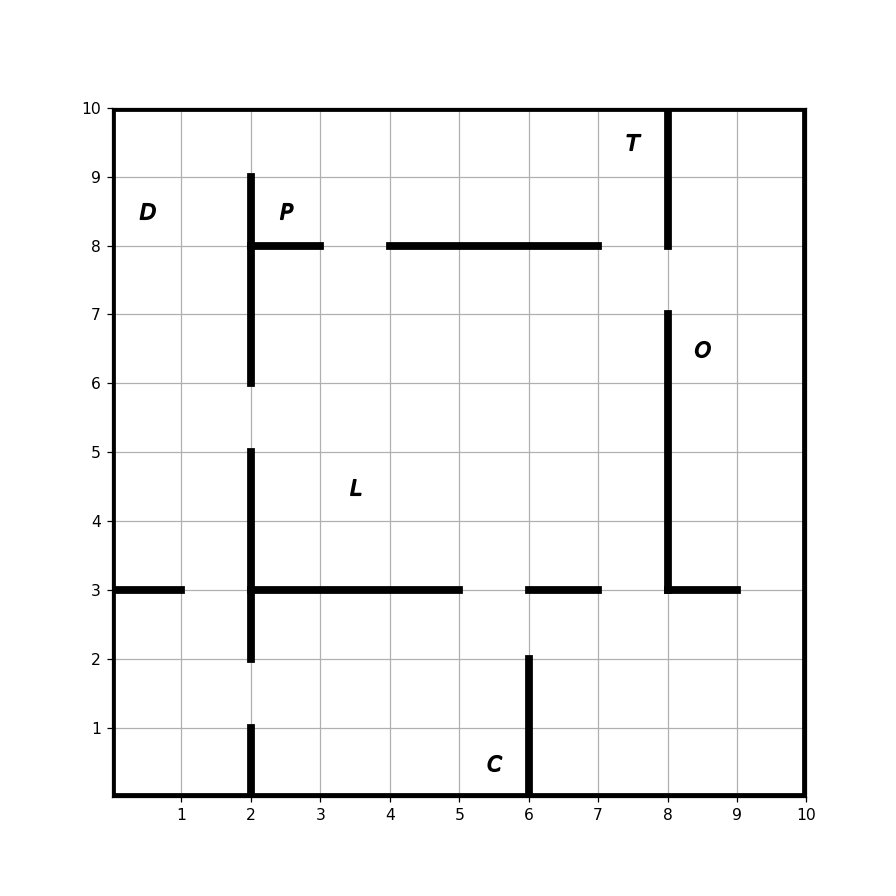

In [82]:
n_rows = 10
n_cols = 10
objs_states = [(9, 3, 'P'), (9, 1, 'D'), (1, 6, 'C'), (5, 4, 'L'), (10, 8, 'T'), (7, 9, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 2.5), (1.5, 2.5)],
         [(3.5, 6.5), (3.5, 7.5)],
         [(3.5, 0.5), (3.5, 1.5)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 10)],
         [(x + 0.5, 6.5) for x in range(0, 3)],
         [(x + 0.5, 8.5) for x in range(3, 8)],
         [(x + 0.5, 8.5) for x in range(8, 11)],
         [(3.5, x + 0.5) for x in range(2, 6)],
         [(3.5, x + 0.5) for x in range(8, 10)],
         [(8.5, x + 0.5) for x in range(2, 4)],
         [(8.5, x + 0.5) for x in range(4, 8)]]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'O'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


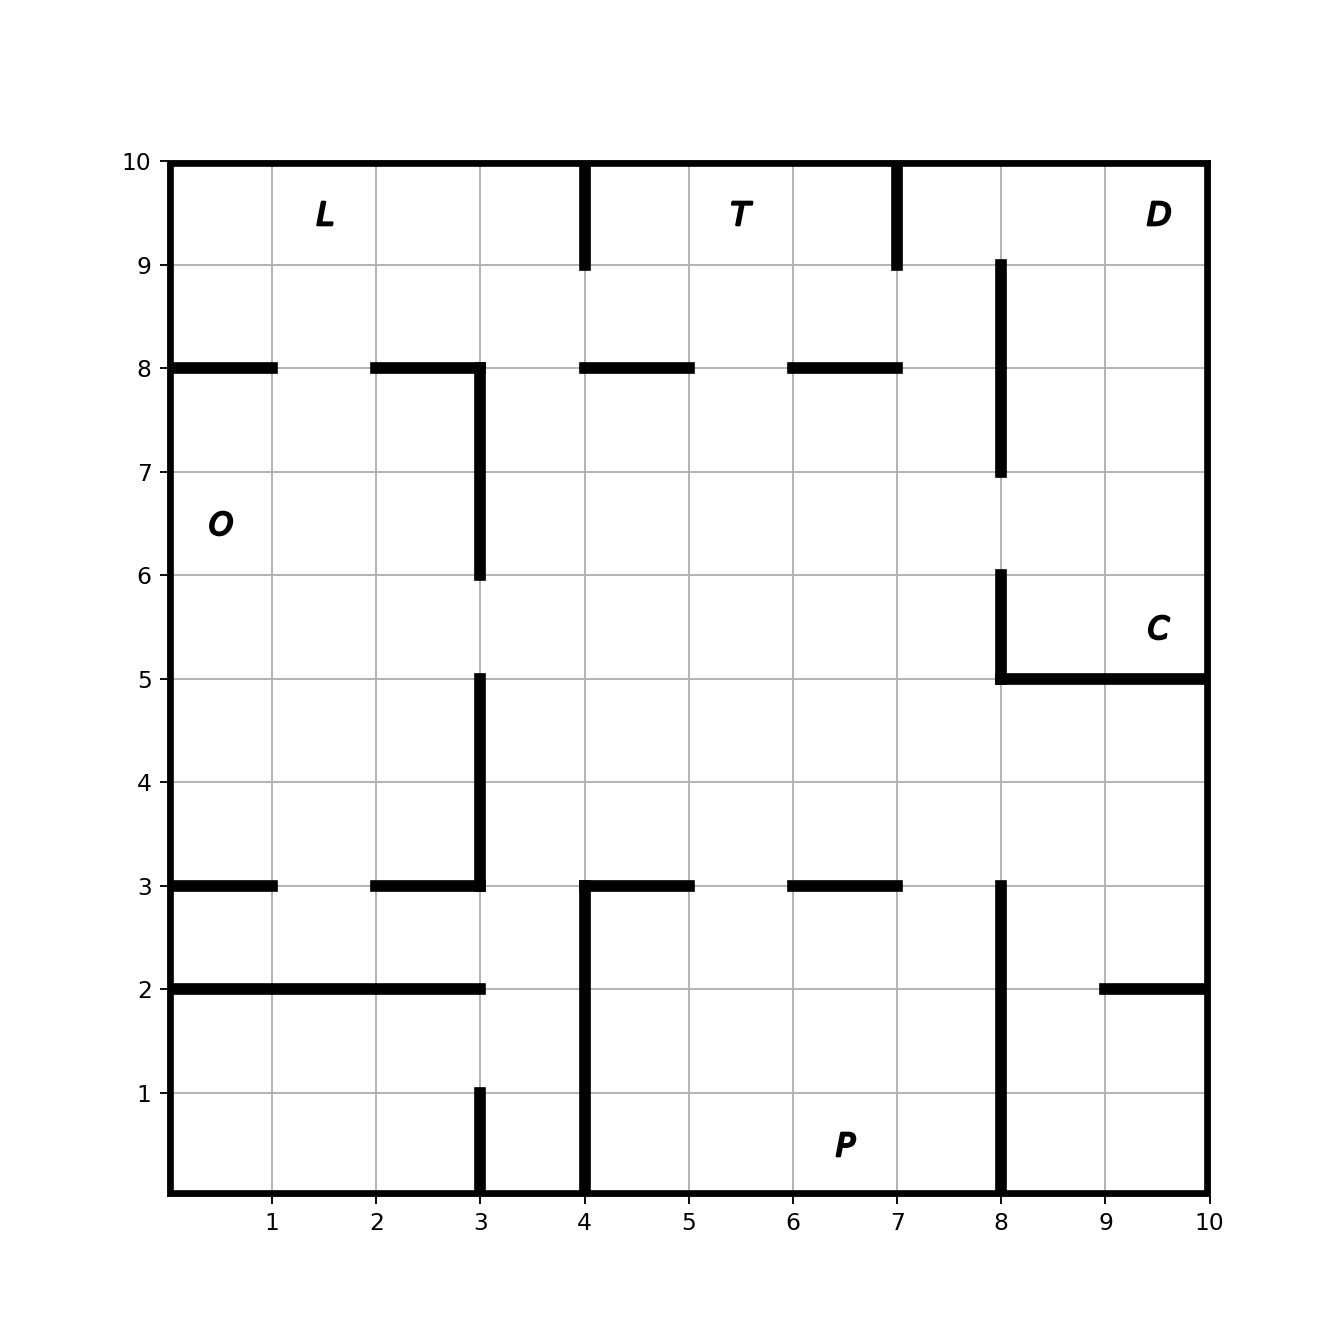

In [50]:
n_rows = 10
n_cols = 10
objs_states = [(1, 7, 'P'), (10, 10, 'D'), (6, 10, 'C'), (10, 2, 'L'), (10, 6, 'T'), (7, 1, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 3.5), (1.5, 3.5)],
         [(x + 0.5, 3.5) for x in range(3, 6)],
         [(x + 0.5, 3.5) for x in range(6, 9)],
         [(x + 0.5, 4.5) for x in range(0, 4)],
         [(x + 0.5, 4.5) for x in range(9, 11)],
         [(x + 0.5, 7.5) for x in range(9, 11)],
         [(x + 0.5, 8.5) for x in range(0, 4)],
         [(x + 0.5, 8.5) for x in range(7, 10)],
         [(x + 0.5, 8.5) for x in range(5, 7)],
         [(2.5, x + 0.5) for x in range(0, 4)],
         [(2.5, x + 0.5) for x in range(9, 11)],
         [(8.5, x + 0.5) for x in range(0, 2)],
         [(8.5, x + 0.5) for x in range(2, 4)],
         [(8.5, x + 0.5) for x in range(4, 6)],
         [(8.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(8, 11)],
         [(3.5, x + 0.5) for x in range(0, 2)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(3.5, x + 0.5) for x in range(4, 6)],
         [(3.5, x + 0.5) for x in range(6, 8)]]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'O'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


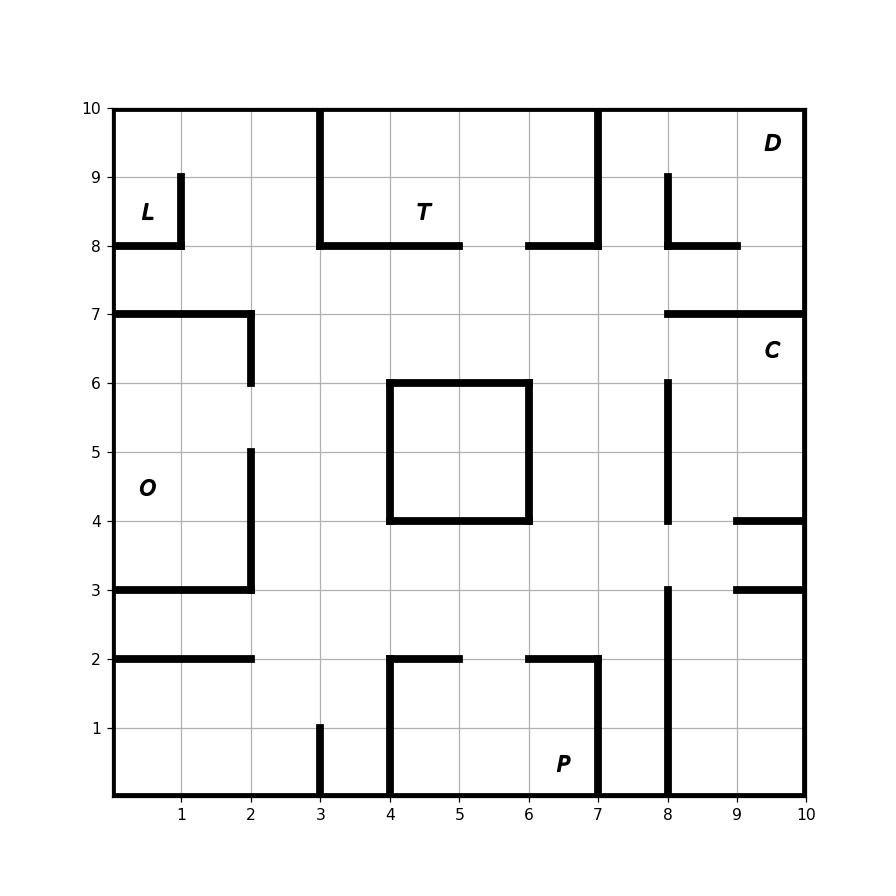

In [55]:
n_rows = 10
n_cols = 10
objs_states = [(1, 7, 'P'), (10, 10, 'D'), (7, 10, 'C'), (9, 1, 'L'), (9, 5, 'T'), (5, 1, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 6.5) for x in range(4, 7)], 
         [(x + 0.5, 4.5) for x in range(4, 7)],
         [(x + 0.5, 2.5) for x in range(3, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 1.5) for x in range(8, 10)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(8, 11)],
         [(x + 0.5, 4.5) for x in range(0, 3)],
         [(x + 0.5, 7.5) for x in range(0, 3)],
         [(x + 0.5, 7.5) for x in range(8, 11)],
         [(x + 0.5, 8.5) for x in range(0, 4)],
         [(x + 0.5, 8.5) for x in range(4, 7)],
         [(x + 0.5, 8.5) for x in range(8, 10)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(2.5, x + 0.5) for x in range(4, 6)],
         [(2.5, x + 0.5) for x in range(6, 8)],
         [(3.5, x + 0.5) for x in range(0, 3)],
         [(3.5, x + 0.5) for x in range(9, 11)],
         [(4.5, x + 0.5) for x in range(9, 11)],
         [(4.5, x + 0.5) for x in range(4, 7)],
         [(6.5, x + 0.5) for x in range(4, 7)],
         [(7.5, x + 0.5) for x in range(0, 3)],
         [(7.5, x + 0.5) for x in range(8, 11)],
         [(8.5, x + 0.5) for x in range(0, 2)],
         [(8.5, x + 0.5) for x in range(3, 6)],
         [(8.5, x + 0.5) for x in range(6, 8)],
         [(8.5, x + 0.5) for x in range(8, 10)]
        ]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T', 'O']
goal = 'D'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


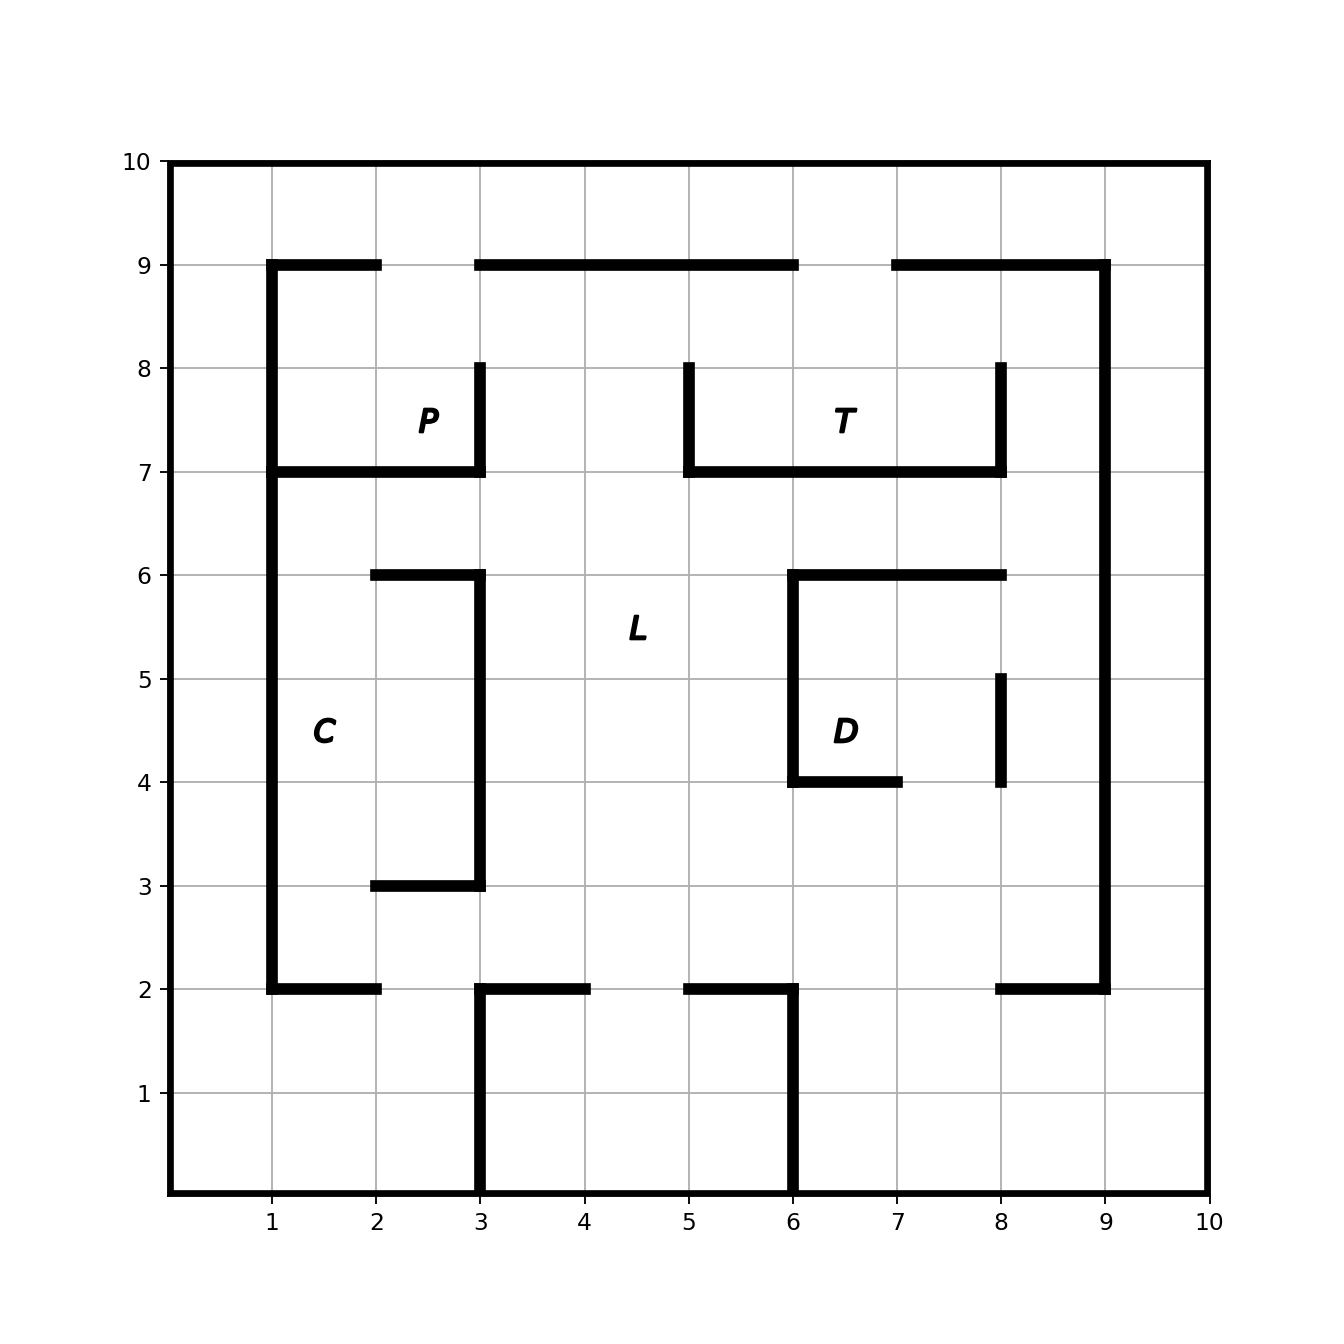

In [18]:
n_rows = 10
n_cols = 10
objs_states = [(8, 3, 'P'), (5, 7, 'D'), (5, 2, 'C'), (6, 5, 'L'), (8, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 1.5) for x in range(2, 10)],
         [(x + 0.5, 3.5) for x in range(0, 3)],
         [(x + 0.5, 3.5) for x in range(3, 7)],
         [(x + 0.5, 3.5) for x in range(7, 9)],
         [(x + 0.5, 5.5) for x in range(7, 9)],
         [(x + 0.5, 6.5) for x in range(0, 3)],
         [(x + 0.5, 6.5) for x in range(4, 7)],
         [(x + 0.5, 8.5) for x in range(4, 6)],
         [(x + 0.5, 8.5) for x in range(7, 9)],
         [(x + 0.5, 9.5) for x in range(2, 10)],
         [(2.5, x + 0.5) for x in range(1, 3)],
         [(2.5, x + 0.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(5, 7)],
         [(2.5, x + 0.5) for x in range(8, 10)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(4.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(2, 4)],
         [(6.5, x + 0.5) for x in range(6, 9)],
         [(7.5, x + 0.5) for x in range(1, 4)],
         [(7.5, x + 0.5) for x in range(5, 9)],
         [(9.5, x + 0.5) for x in range(1, 3)],
         [(9.5, x + 0.5) for x in range(3, 7)],
         [(9.5, x + 0.5) for x in range(7, 10)]
        ]
x0 = '1 1 N'
goals = ['P', 'D', 'C', 'L', 'T']
goal = 'T'
max_goal_len = max([len(g) for g in goals]) + 2

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [25]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
max_goal_len = max([len(g) for g in goals]) + 2
# wacmw = WallAutoCollectMazeWorld()
# X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15)
wacmw = WallCollectMazeWorld()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.5, max_goal_len)
# wacmw = LimitedCollectWallMazeWorld()
# X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15, max_goal_len)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
v_mdps_w = []
q_mdps_w = []
task_mdps_w = {}
costs = []
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = wacmw.generate_rewards(goals[i], X_w, A_w)
    costs += [c]
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]), 'reward')
    pol, q = mdp.policy_iteration()
    v = mdp.evaluate_pol(pol)
    q_mdps_w += [q]
    v_mdps_w += [v]
    mdps_w['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
task_mdp_w = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[i], objs_states, goals, 1.0, get_goal_states(X_w, goals[i]), 1, 
                     'leg_pure', q_mdps=q_mdps_w, v_mdps=v_mdps_w)

leg_costs = [task_mdp_w.costs[idx] for idx in range(len(goals))]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration(goals.index(goal))
print('Took %.3f seconds to compute policy' % (time.time() - time1))

##########################################
#####  Wall Auto Collect Maze World  #####
##########################################


Single Task MDPs:   0%|                                                                          | 0/5 [00:00<?, ?it/s]

### Computing Costs and Creating Task MDPs ###
N. iterations:  3


Single Task MDPs:  20%|█████████████▏                                                    | 1/5 [00:01<00:06,  1.73s/it]

[[ 2.45441937]
 [10.        ]
 [ 0.        ]
 ...
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
N. iterations:  3


Single Task MDPs:  40%|██████████████████████████▍                                       | 2/5 [00:03<00:04,  1.64s/it]

[[ 2.9998459]
 [ 0.       ]
 [10.       ]
 ...
 [10.       ]
 [10.       ]
 [ 0.       ]]
N. iterations:  3


Single Task MDPs:  60%|███████████████████████████████████████▌                          | 3/5 [00:04<00:03,  1.58s/it]

[[ 3.66647832]
 [ 0.        ]
 [ 0.        ]
 ...
 [10.        ]
 [ 0.        ]
 [10.        ]]
N. iterations:  3


Single Task MDPs:  60%|███████████████████████████████████████▌                          | 3/5 [00:06<00:04,  2.00s/it]


KeyboardInterrupt: 

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 627.14it/s]

Initial State: 1 5 N
##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
Optimal trajectory for task: T
Trajectory: ['1 5 N' '2 5 N' '3 5 N' '3 5 N' '3 5 N' '3 5 N' '3 5 N' '3 6 N' '4 6 N'
 '4 6 N' '5 6 N' '5 6 N' '6 6 N' '7 6 N' '7 6 N' '7 5 N' '8 5 N' '8 5 N'
 '8 5 N' '9 5 N' '9 5 N' '9 6 N' '9 6 N' '9 7 N' '9 7 N' '9 7 N' '8 7 T']
Cost: 0.06461081889226679
Legible Reward: 0.2909705674125985
Legible trajectory for task: T
Trajectory: ['1 5 N' '1 5 N' '1 5 N' '2 5 N' '3 5 N' '3 5 N' '3 5 N' '3 5 N' '3 5 N'
 '3 5 N' '3 5 N' '3 4 N' '3 4 N' '4 4 N' '5 4 N' '5 4 N' '6 4 N' '7 4 N'
 '8 4 N' '8 4 N' '8 4 N' '8 4 N' '9 4 N' '9 4 N' '9 4 N' '9 5 N' '9 5 N'
 '9 6 N' '9 6 N' '8 6 N' '8 7 T']
Cost: 0.042391158275216244
Legible Reward: 0.2048264561844926


<IPython.core.display.Javascript object>


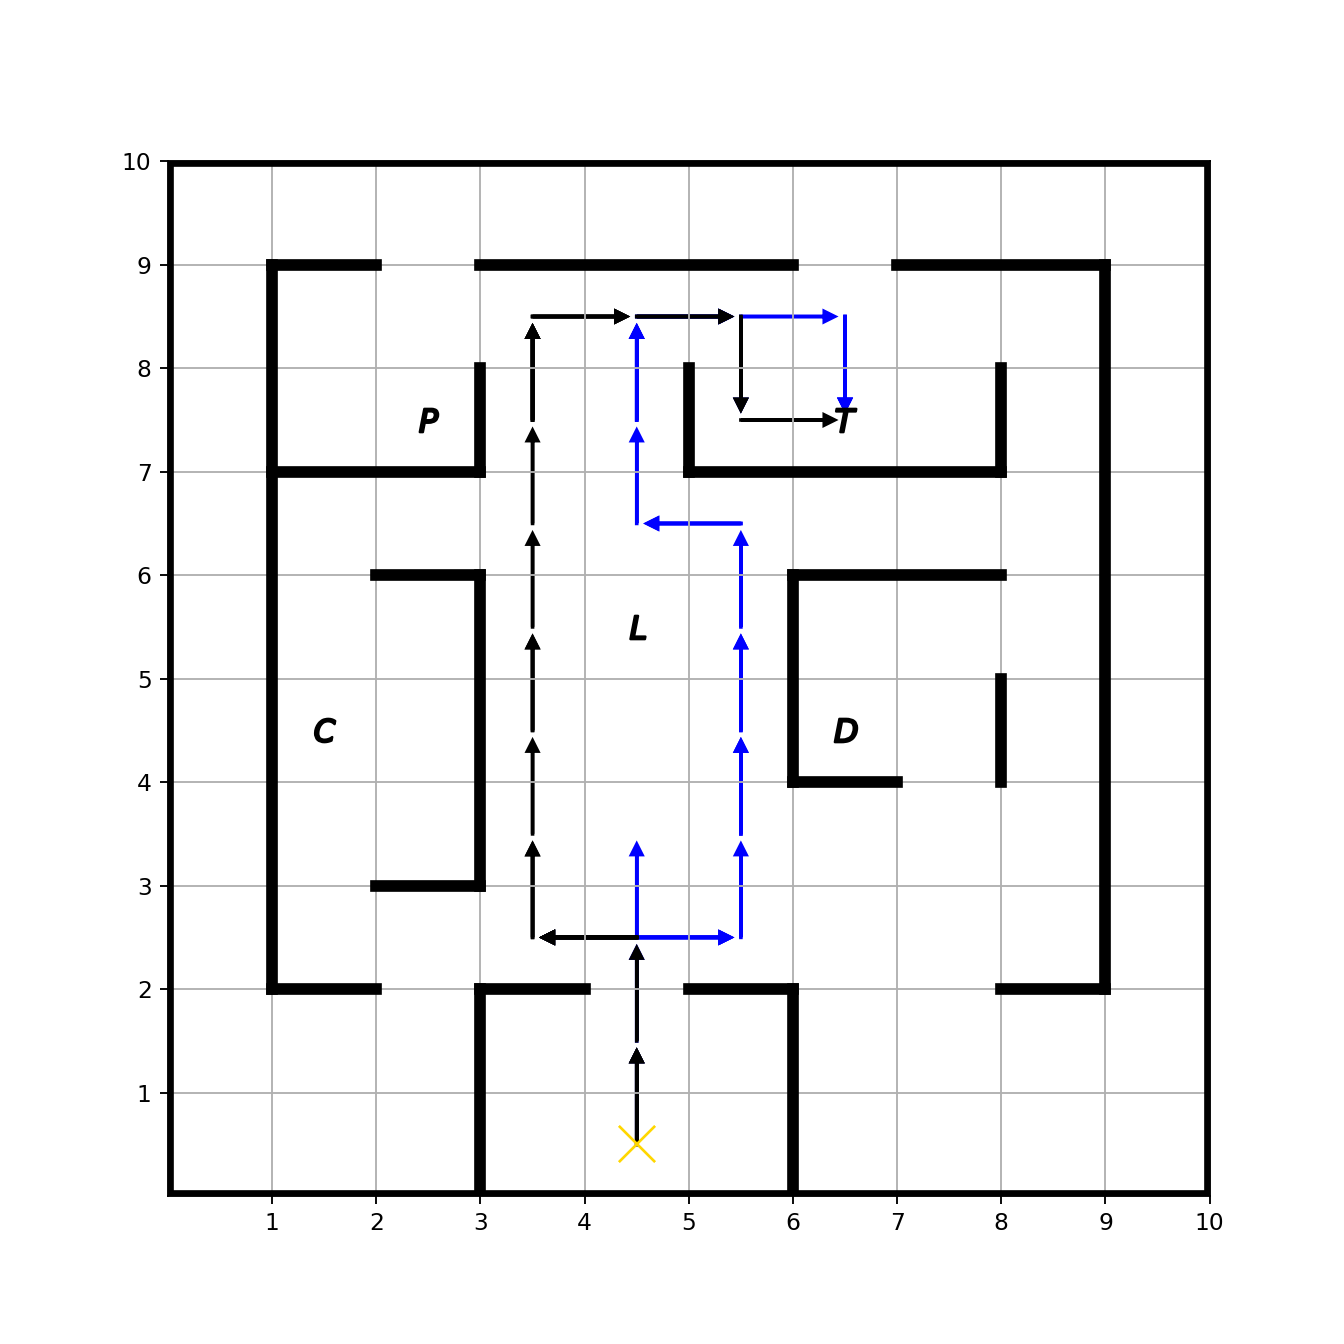

Simulate Trajectories:   1%|▌                                                       | 11/1000 [00:00<00:09, 105.07it/s]

Getting model performance!!


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1059.74it/s]

Simulation length = 13.511
Optimal Policy performance:
Cost: 0.075
Legible Reward: 0.249
Legible Policy performance:
Cost: 0.074
Legible Reward: 0.256


In [31]:
x0 = '1 5 N'
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward(goals.index(goal), [[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward(goals.index(goal), [[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

figure = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, figure, 'b')
visualize_trajectory(t_leg[0], t_leg, figure, 'k')
fig, _ = figure
fig.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
                                                task_mdp_w, task_pol_w, x0, 1000, goals.index(goal))
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('Legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

Optimal trajectories: 1001


<IPython.core.display.Javascript object>


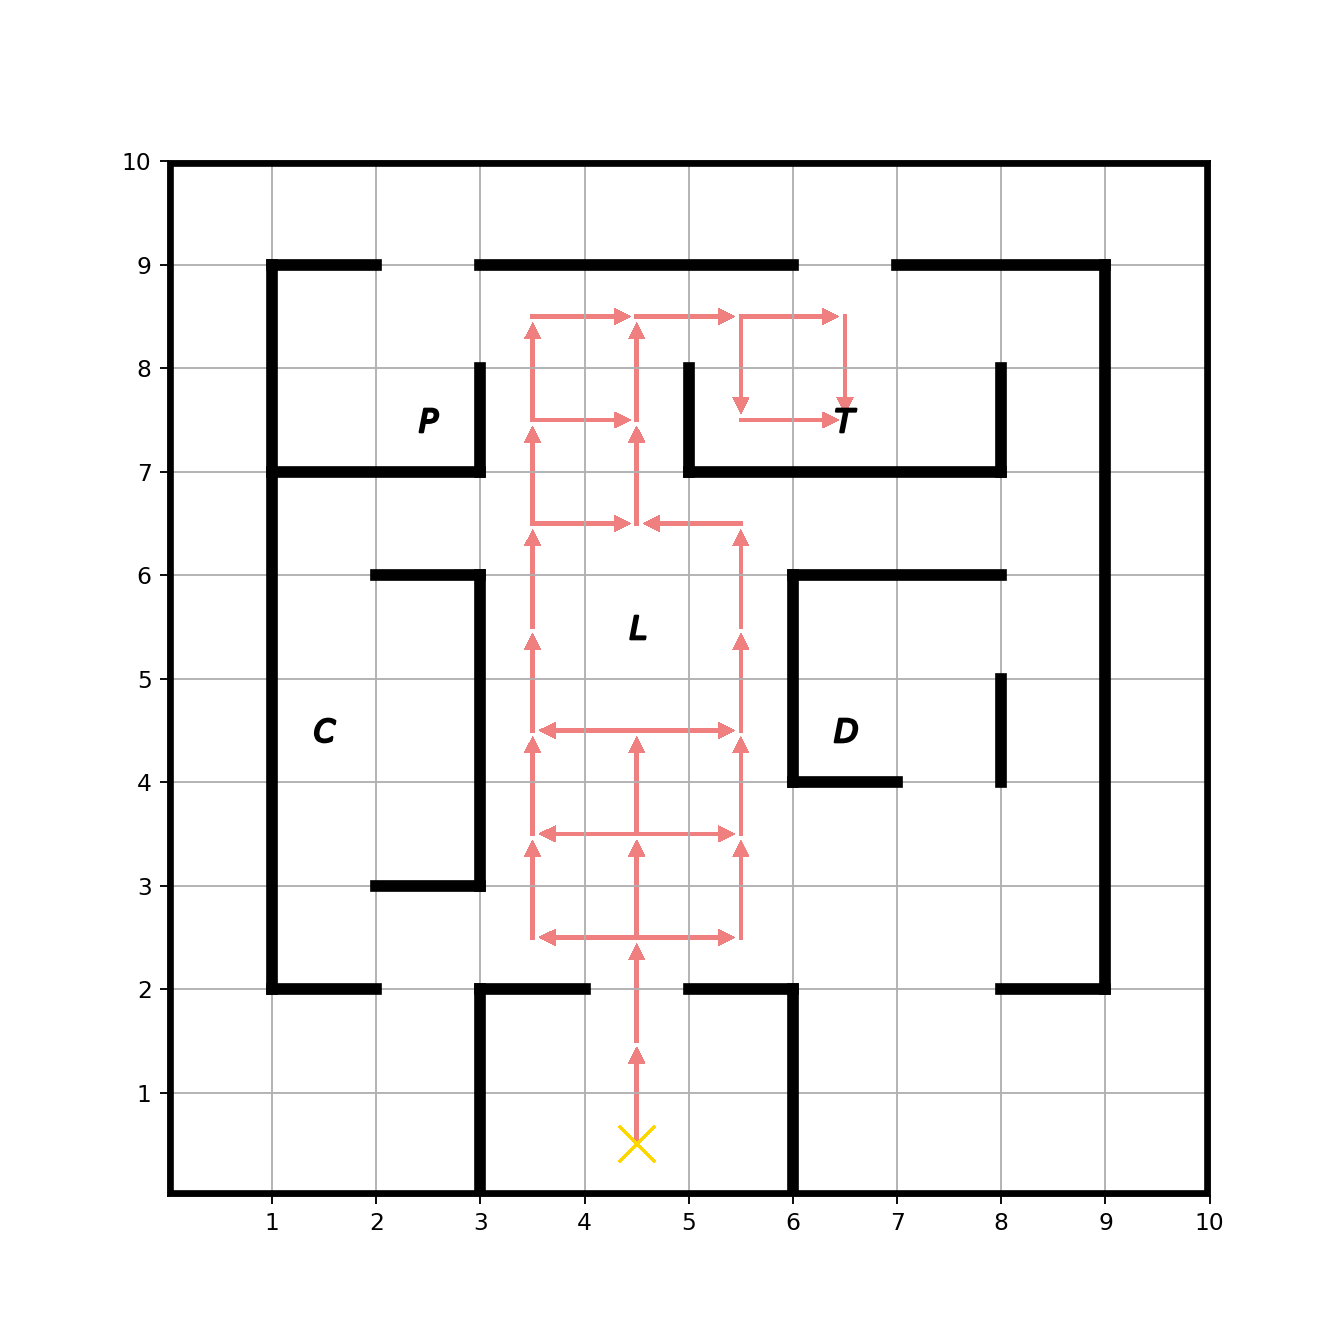

Legible trajectories: 1


<IPython.core.display.Javascript object>


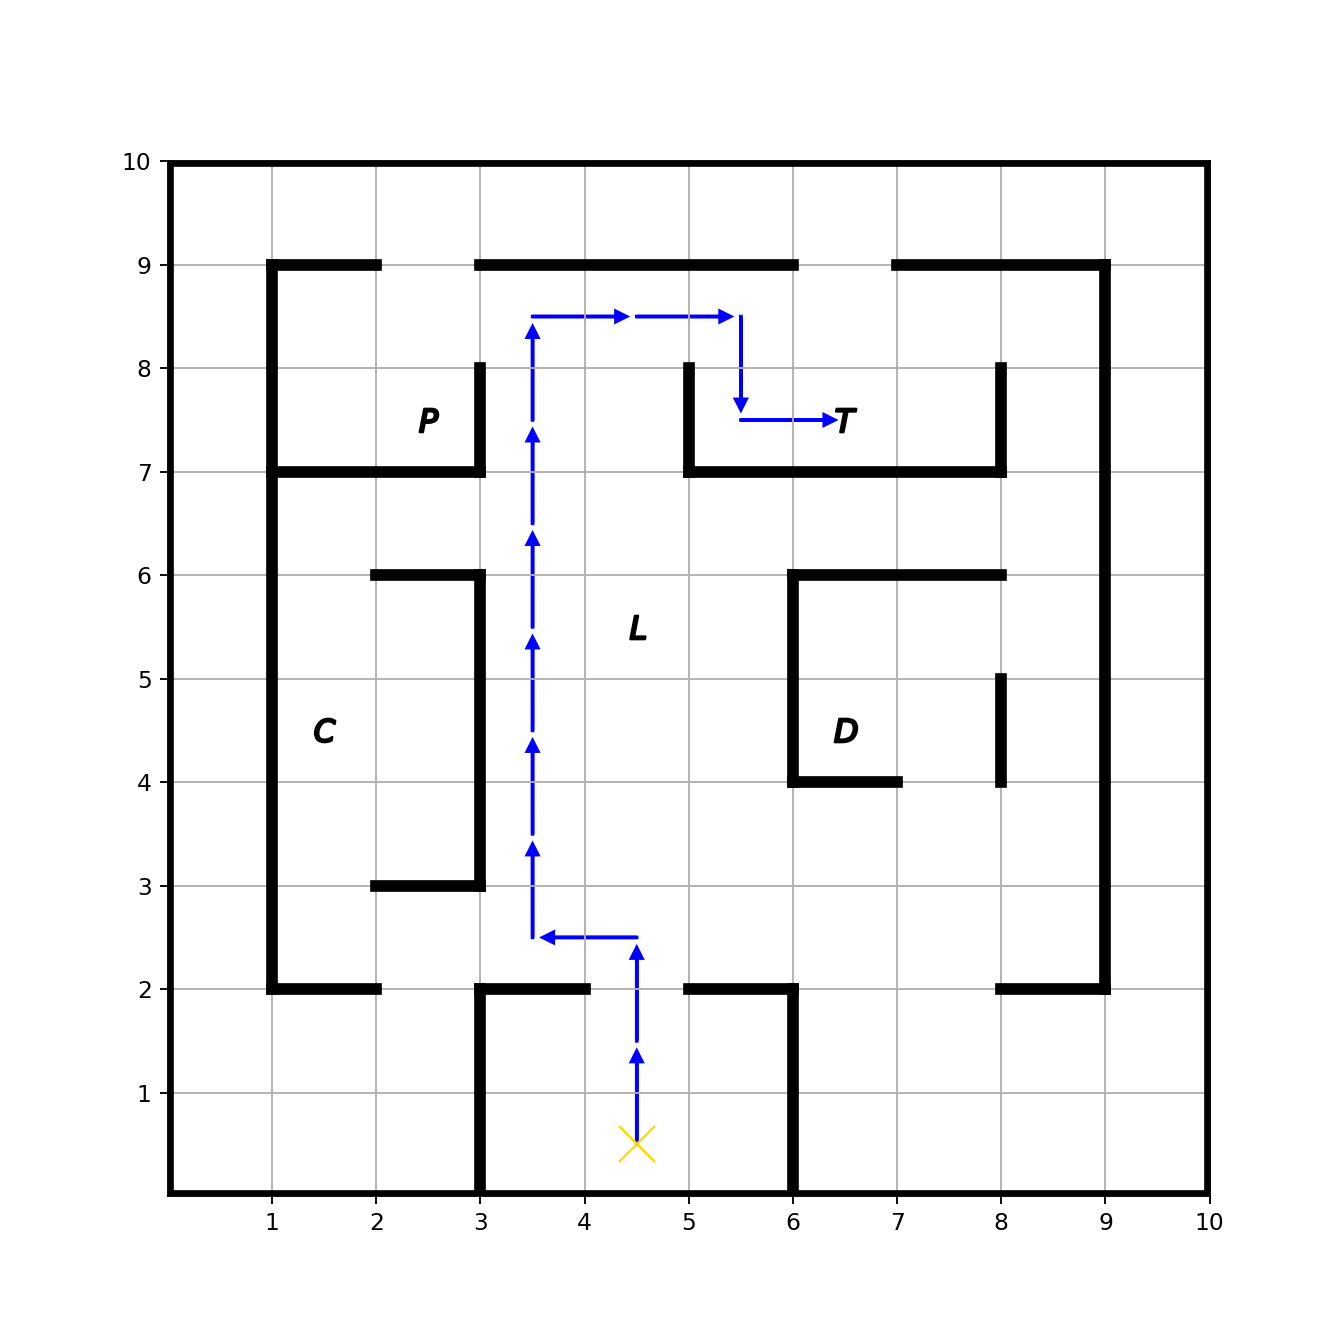

In [32]:
colors = ['blue', 'darkred', 'green', 'black', 'orange', 'pink', 'yellow', 'magenta', 'brown', 'cyan', 'khaki', 'olivedrab', 'lightcoral']
trajs, a_trajs = mdps_w['mdp' + str(goals.index(goal) + 1)].all_trajectories(x0, pol_w)
print('Optimal trajectories: %d' % len(trajs))
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(trajs)):
    traj = trajs[j]
    a_traj = a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors) - 1)])
    i += 1
fig, _ = fig
fig.show()
leg_trajs, leg_a_trajs = task_mdp_w.all_trajectories(x0, task_pol_w)
print('Legible trajectories: %d' % len(leg_trajs))
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(leg_trajs)):
    traj = leg_trajs[j]
    a_traj = leg_a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors) - 1)])
    i += 1
fig, _ = fig
fig.show()

Goal: P
N. iterations:  3
N. iterations:  9


<IPython.core.display.Javascript object>


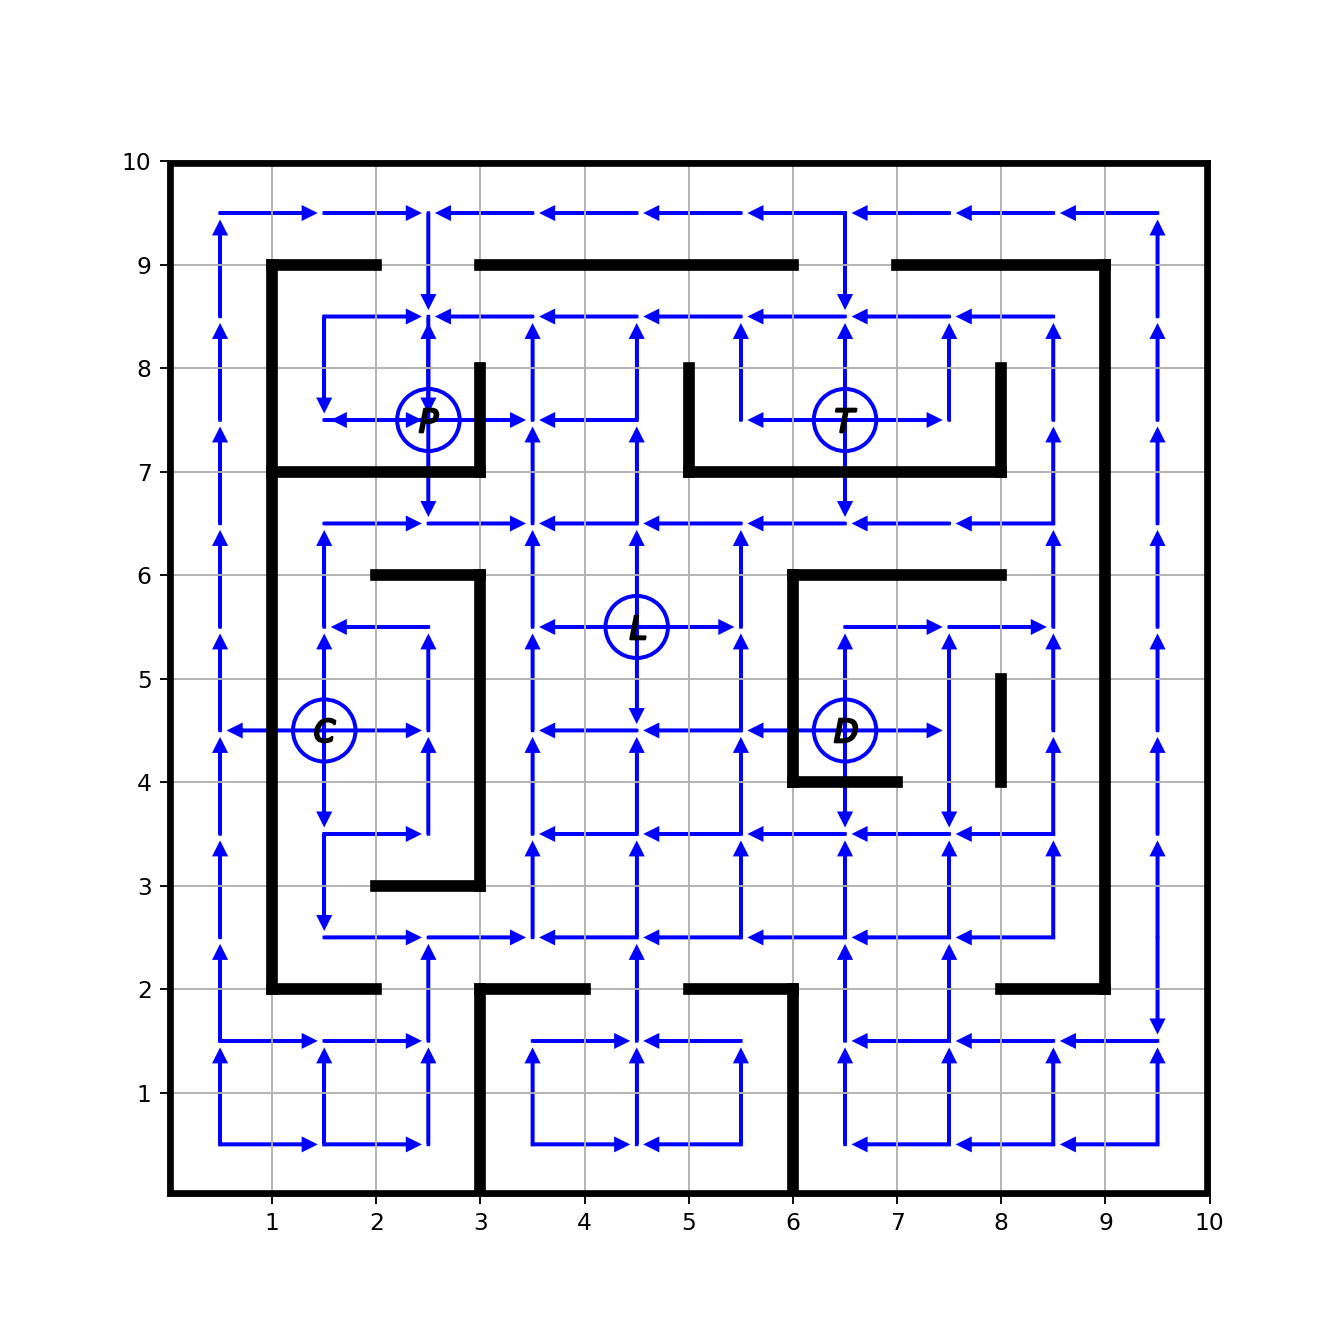

<IPython.core.display.Javascript object>


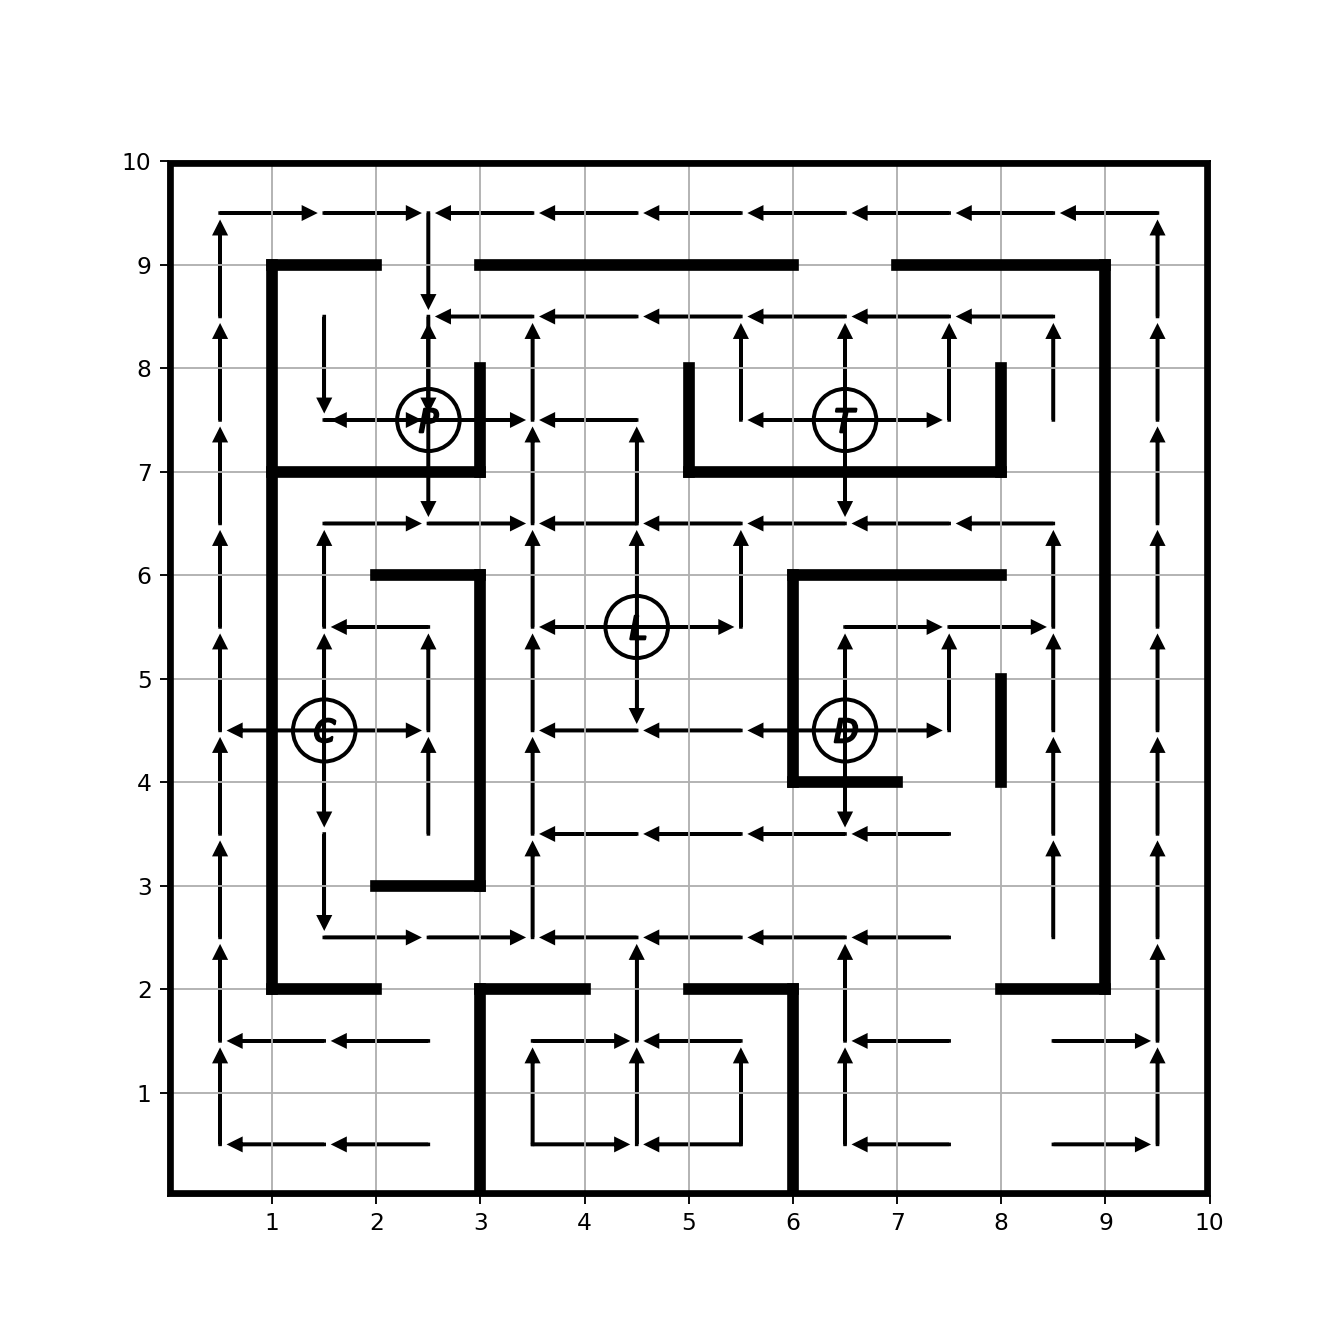

Goal: D
N. iterations:  3
N. iterations:  8


<IPython.core.display.Javascript object>


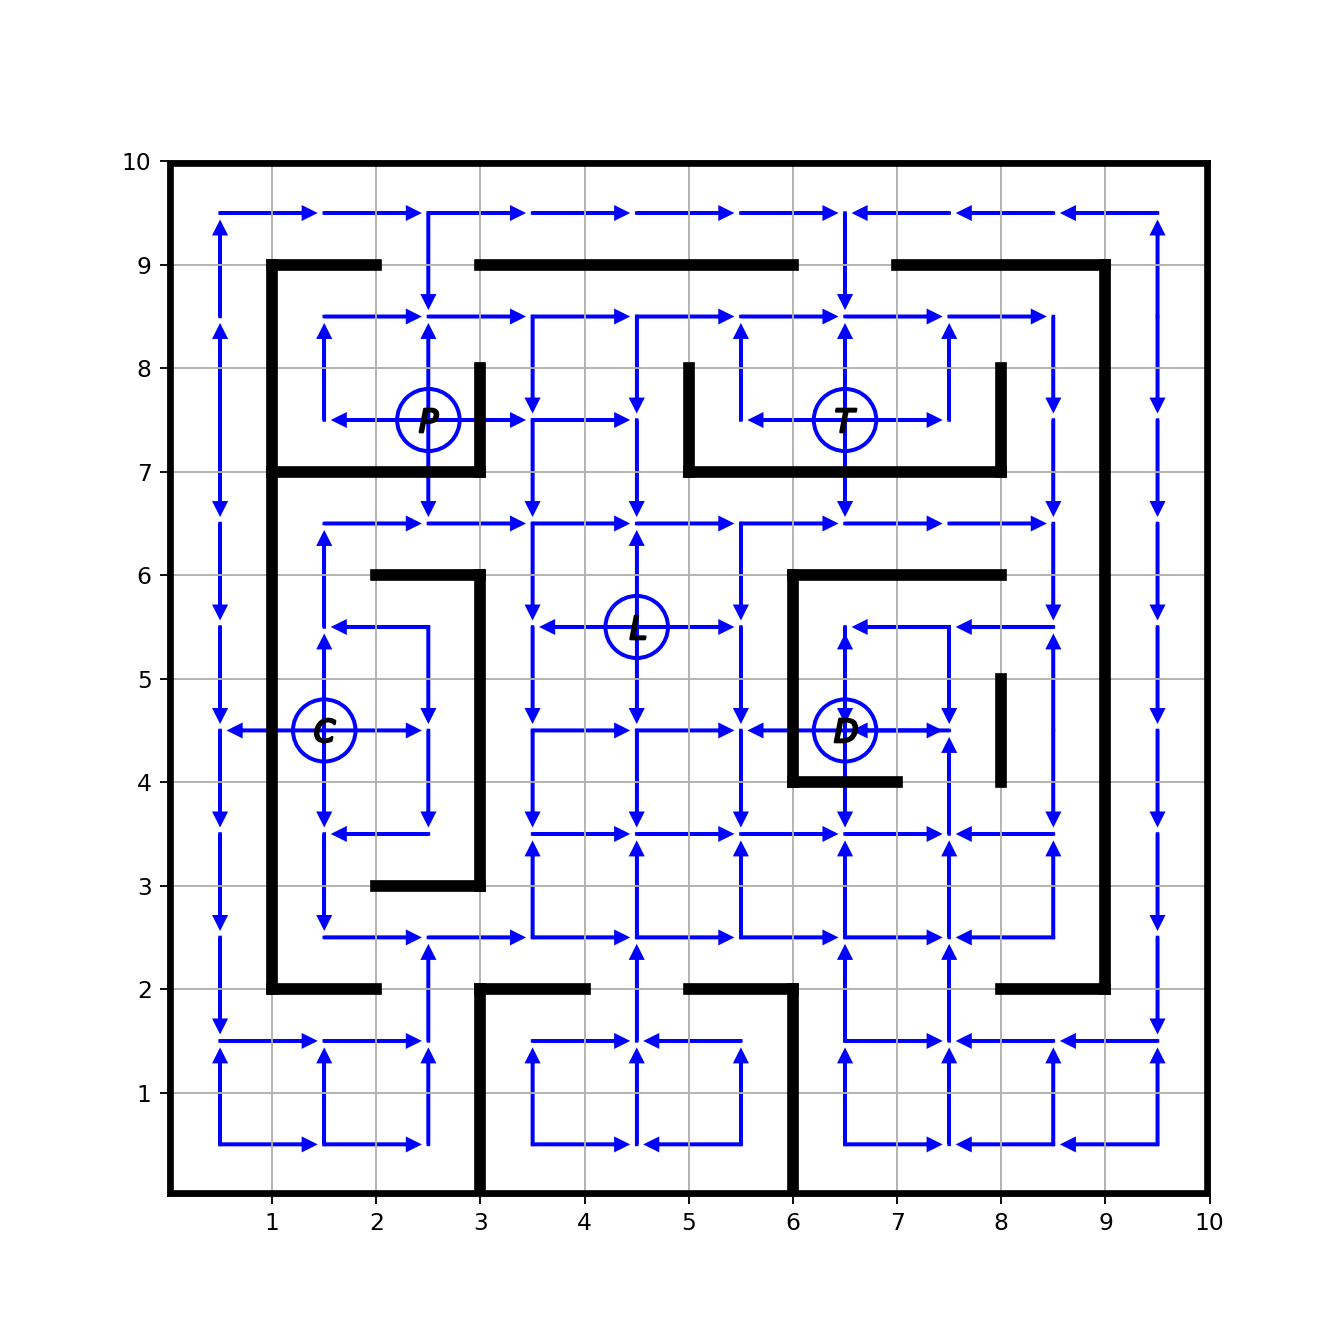

C:\Program Files\Python37\Lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


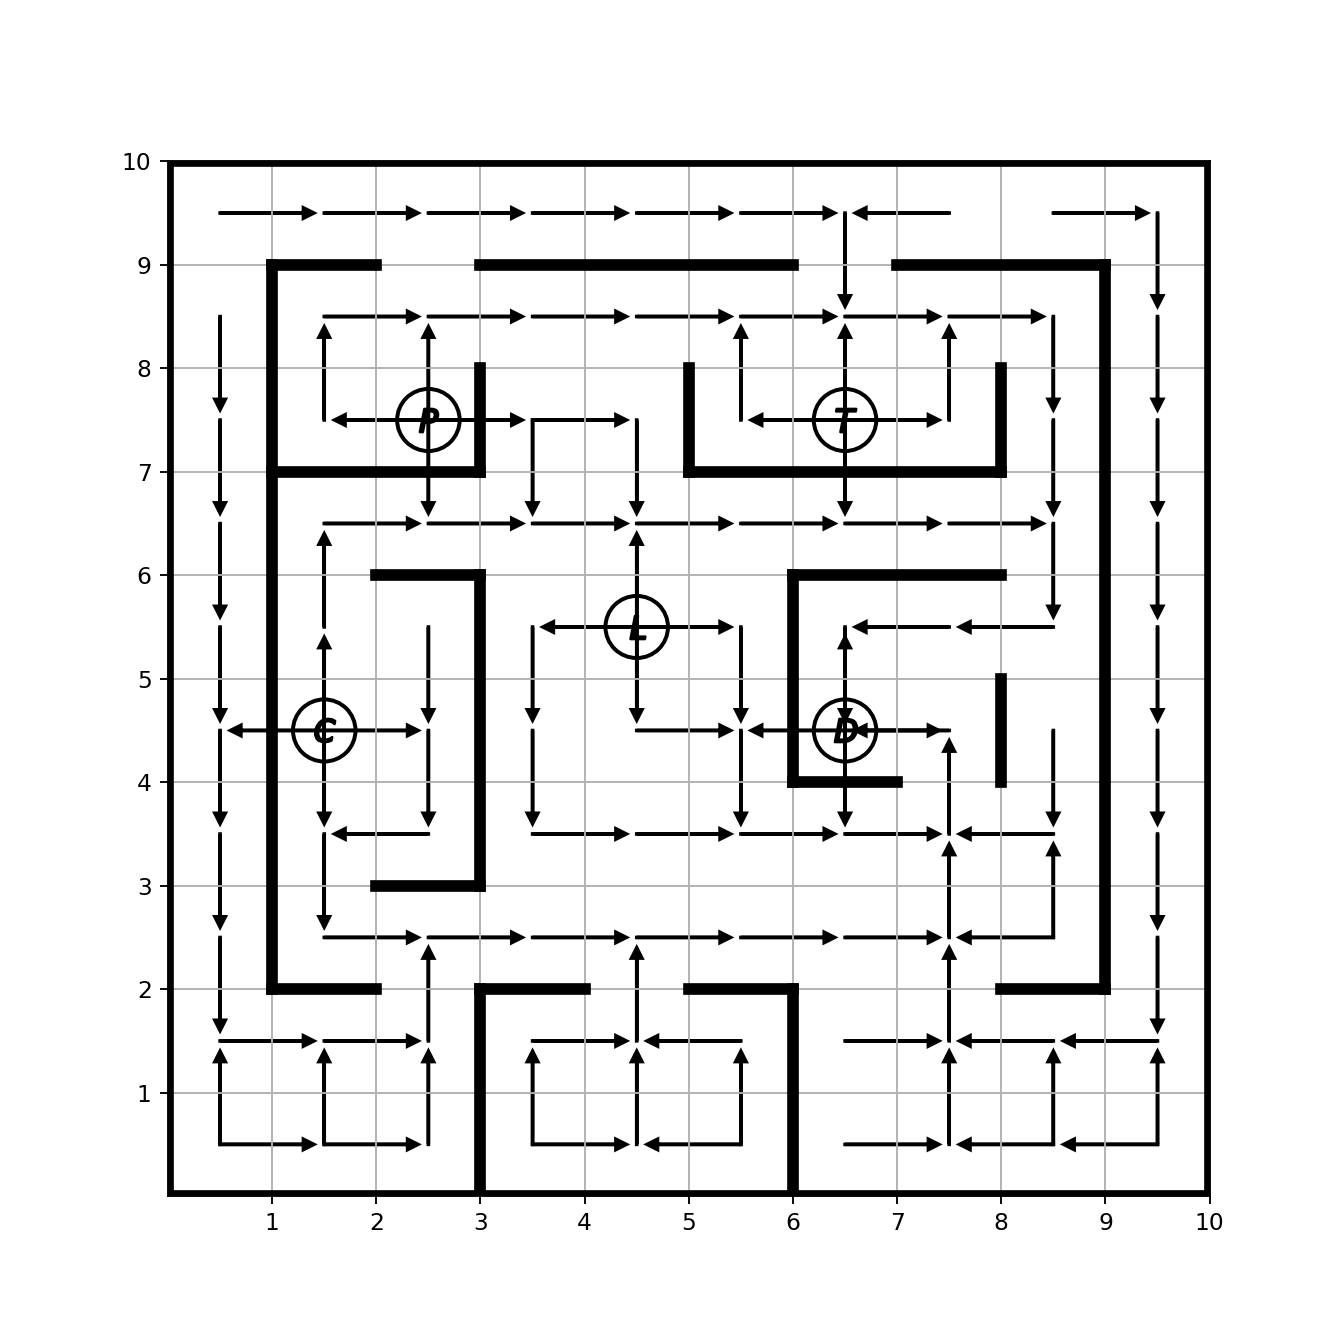

Goal: C
N. iterations:  3
N. iterations:  8


<IPython.core.display.Javascript object>


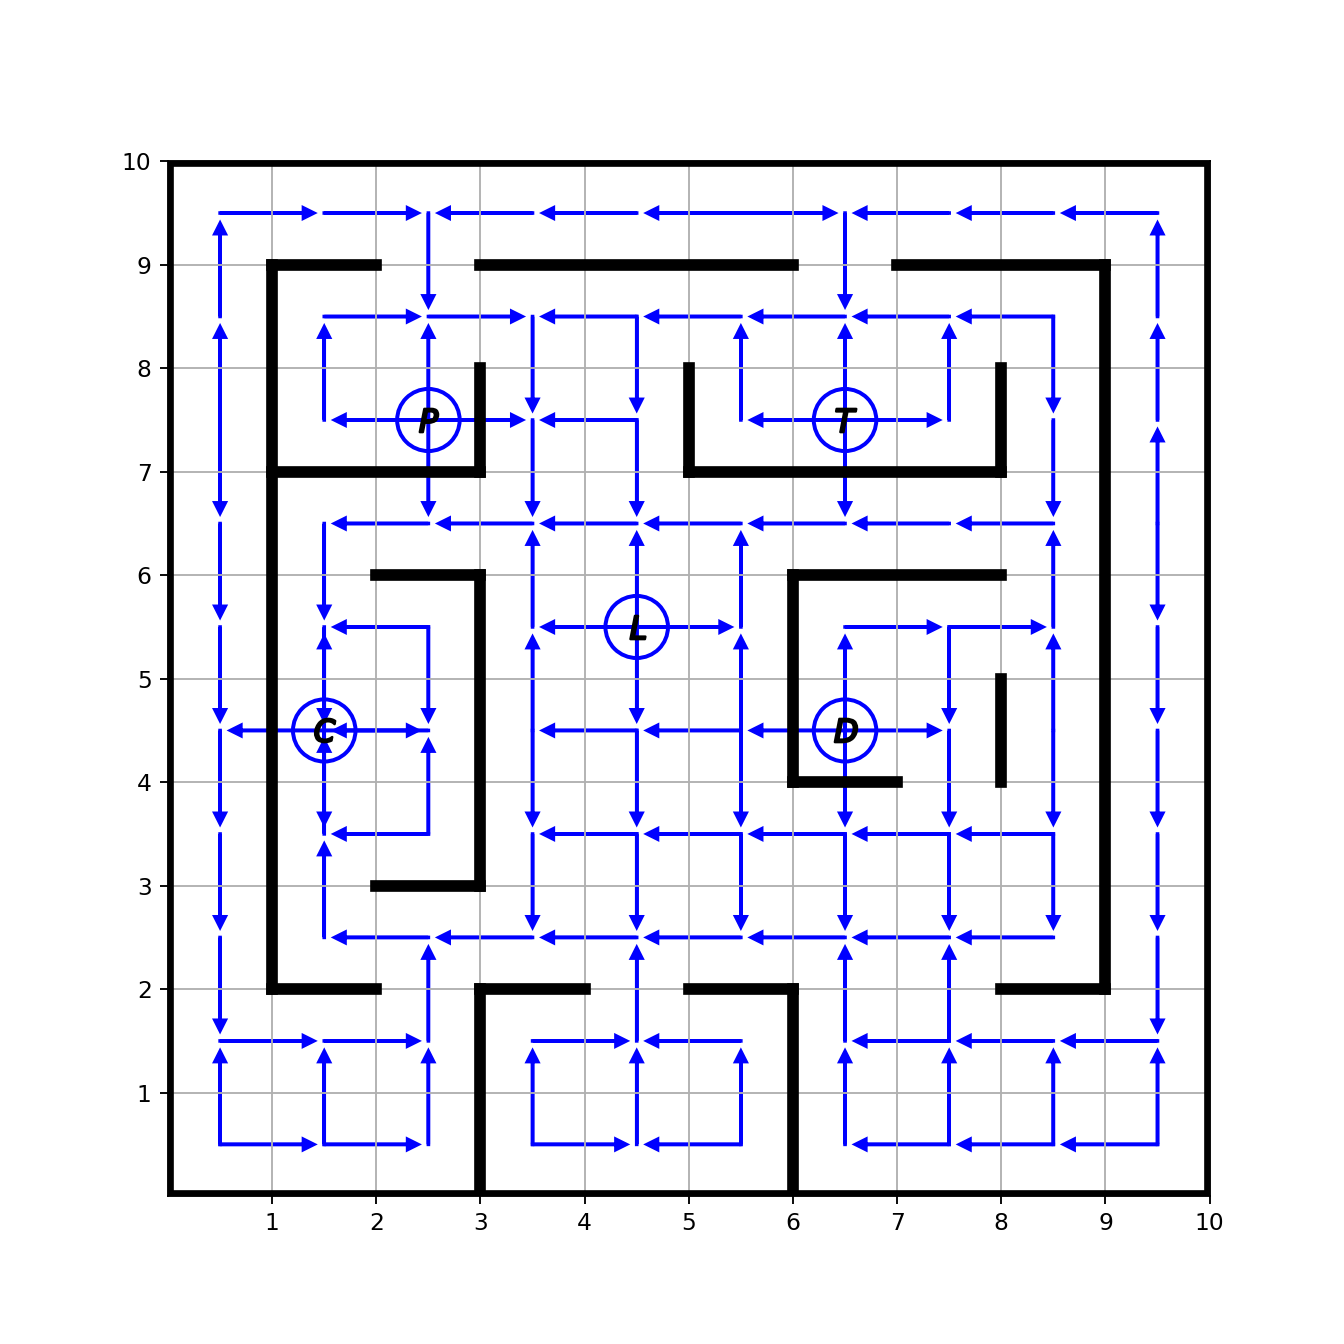

<IPython.core.display.Javascript object>


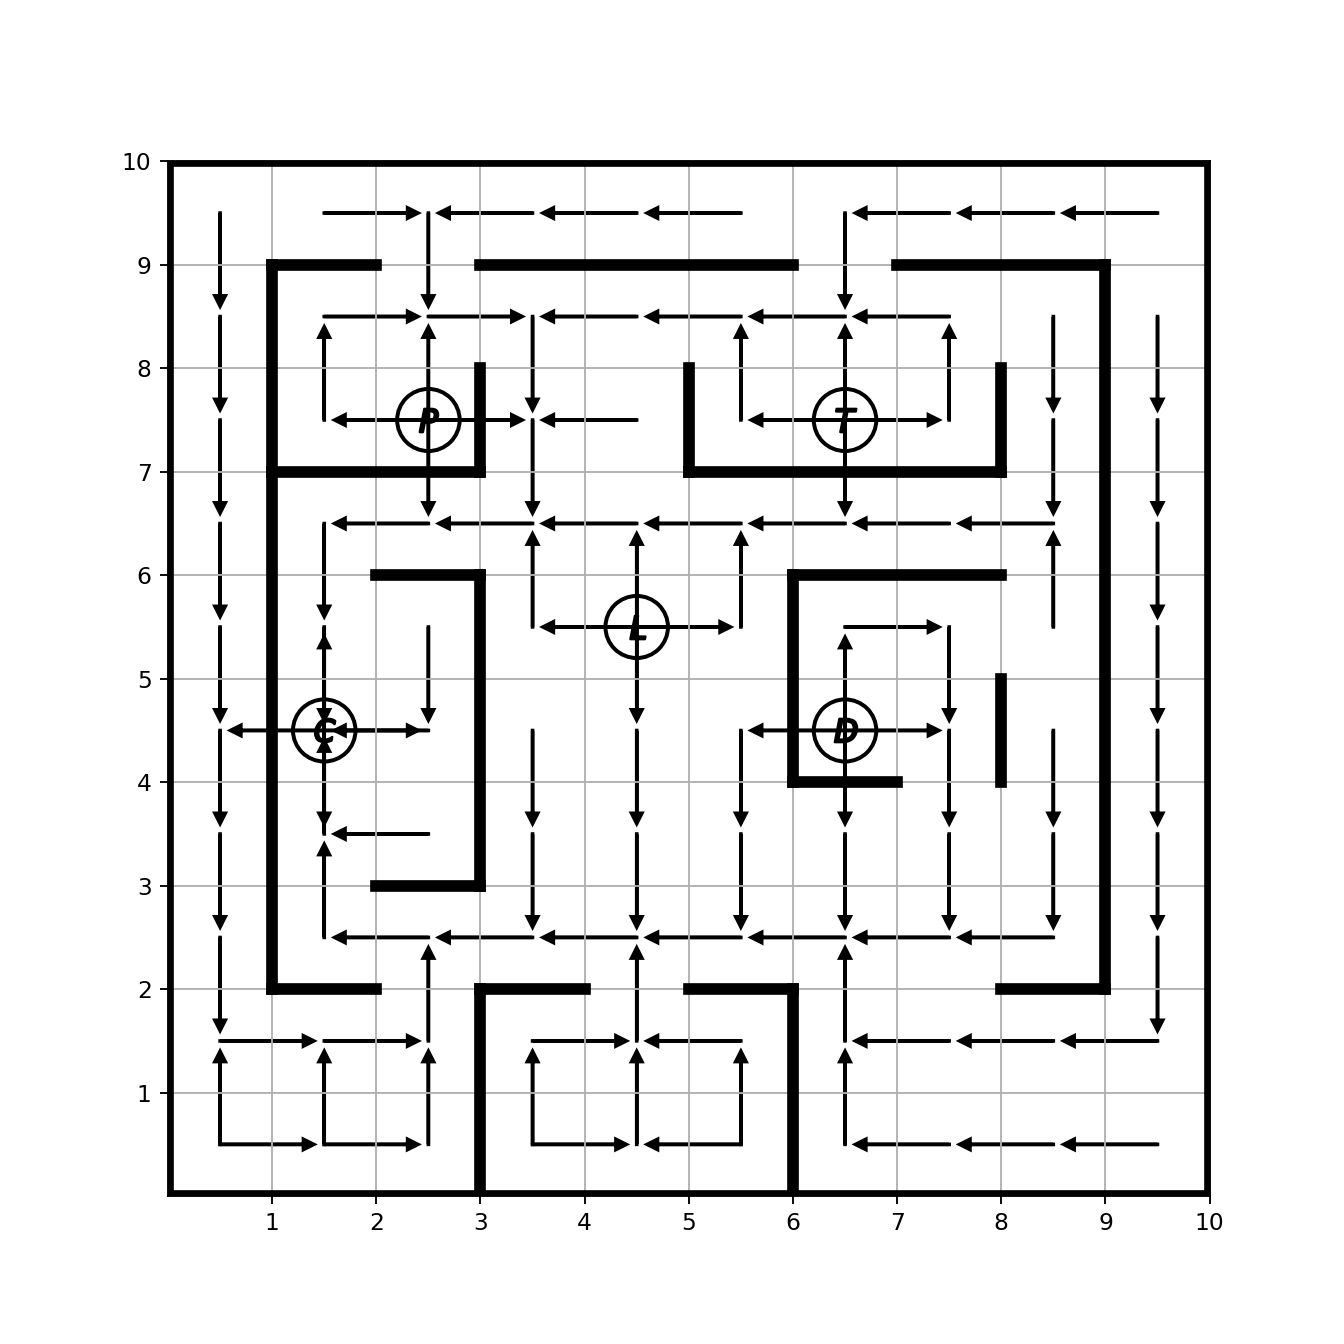

Goal: L
N. iterations:  3
N. iterations:  8


<IPython.core.display.Javascript object>


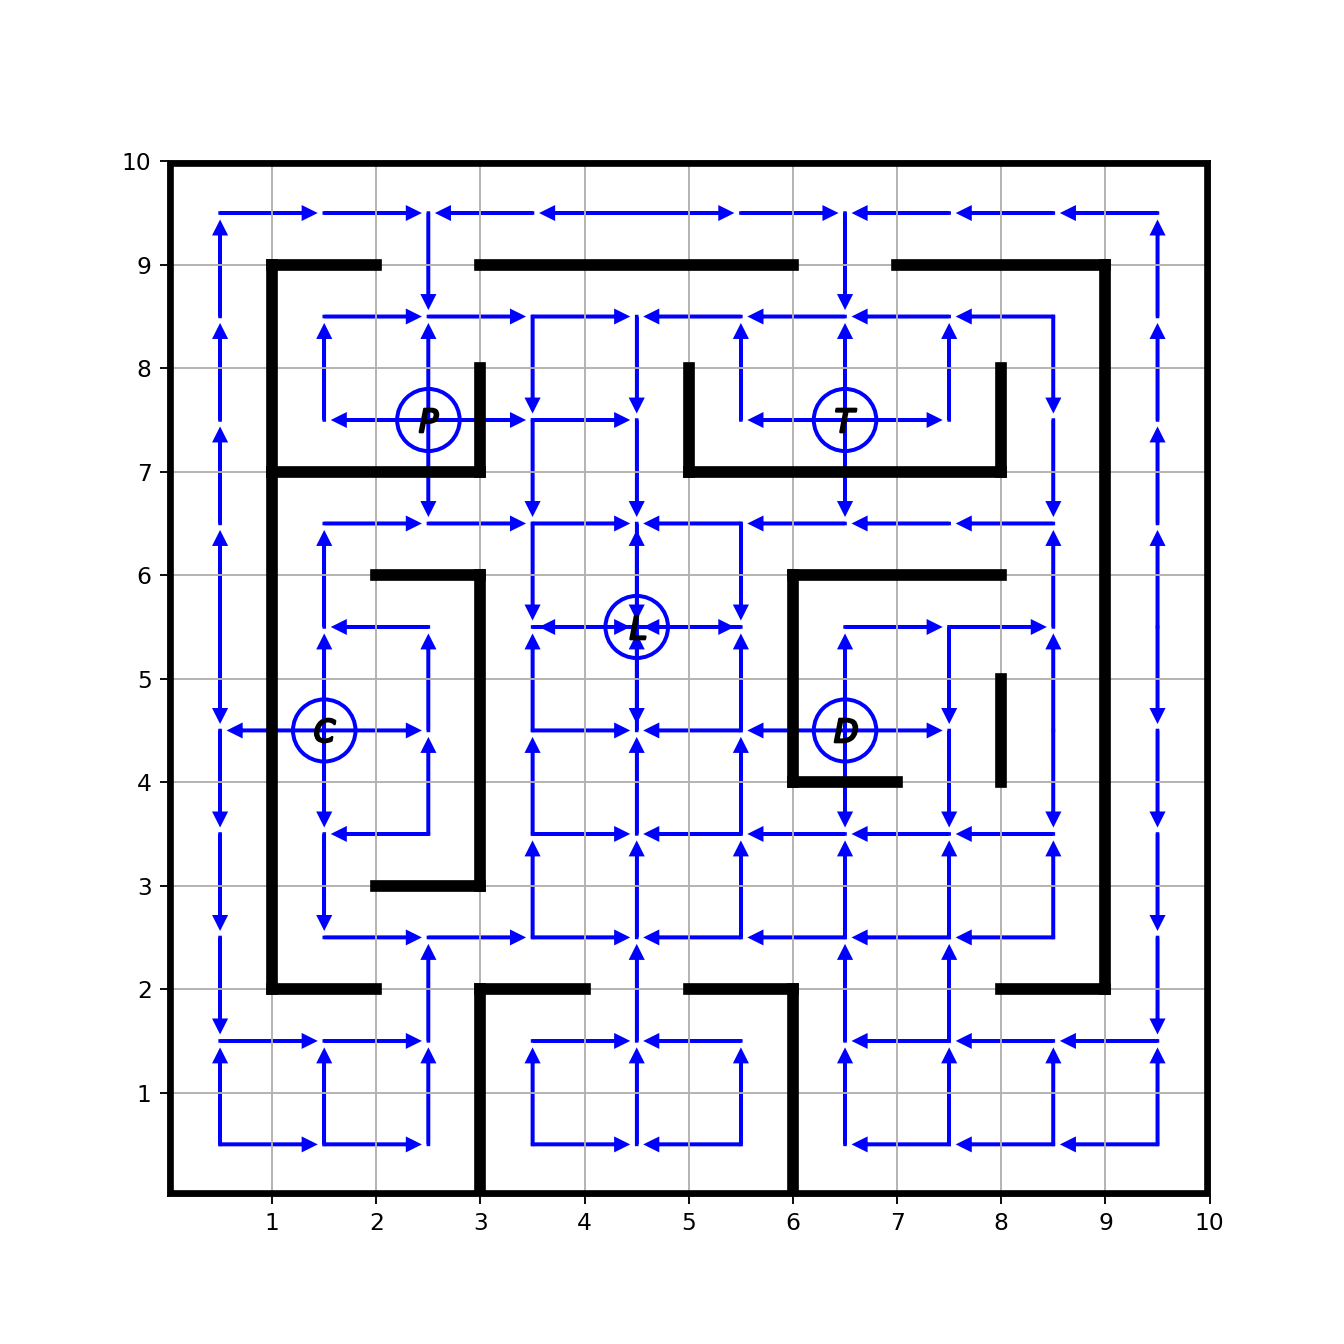

<IPython.core.display.Javascript object>


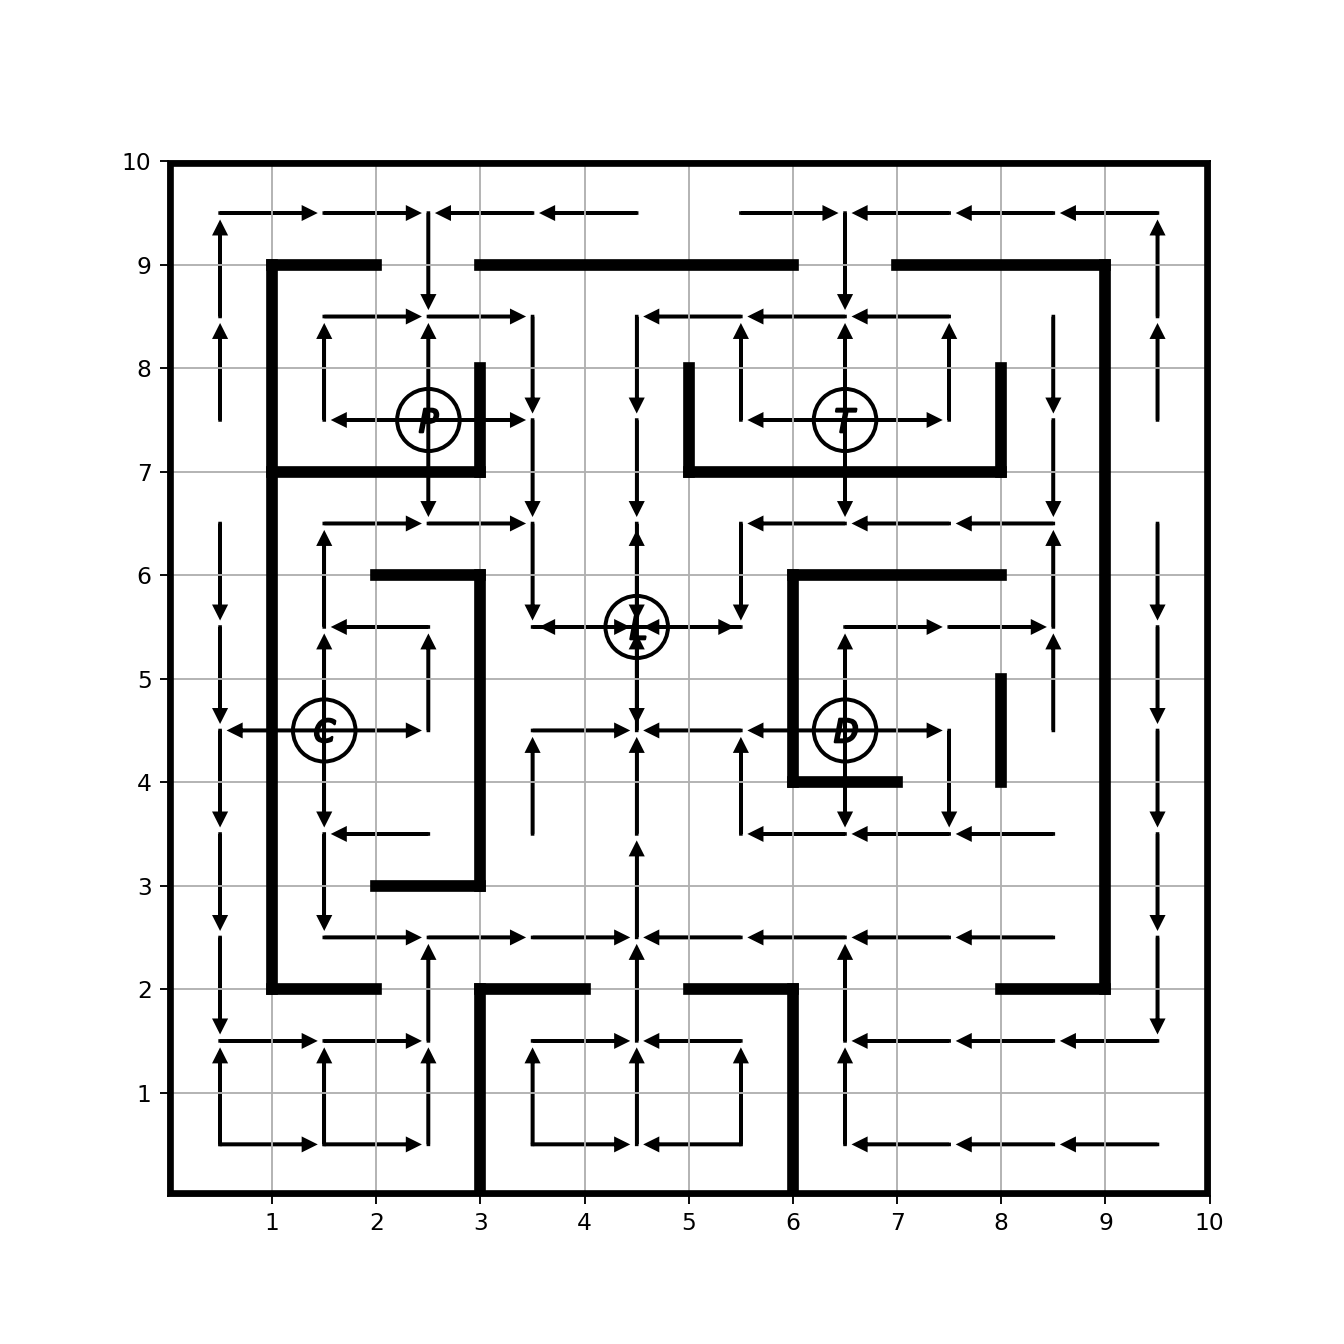

Goal: T
N. iterations:  3
N. iterations:  7


<IPython.core.display.Javascript object>


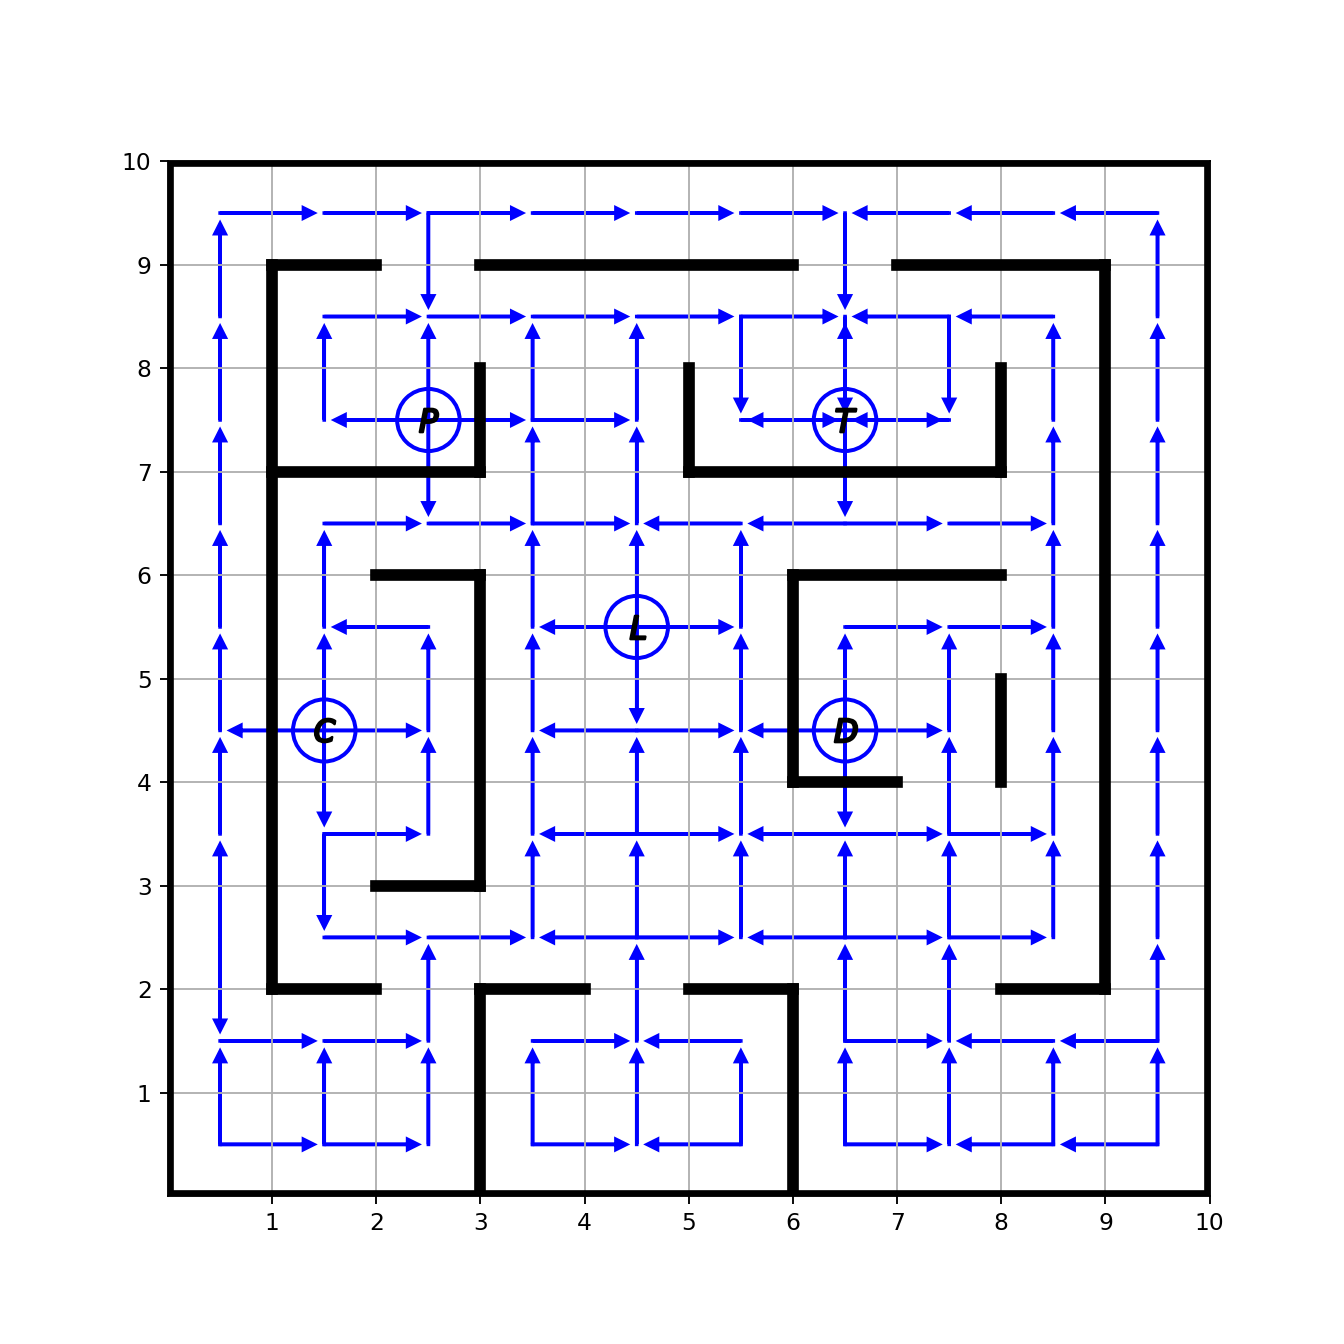

<IPython.core.display.Javascript object>


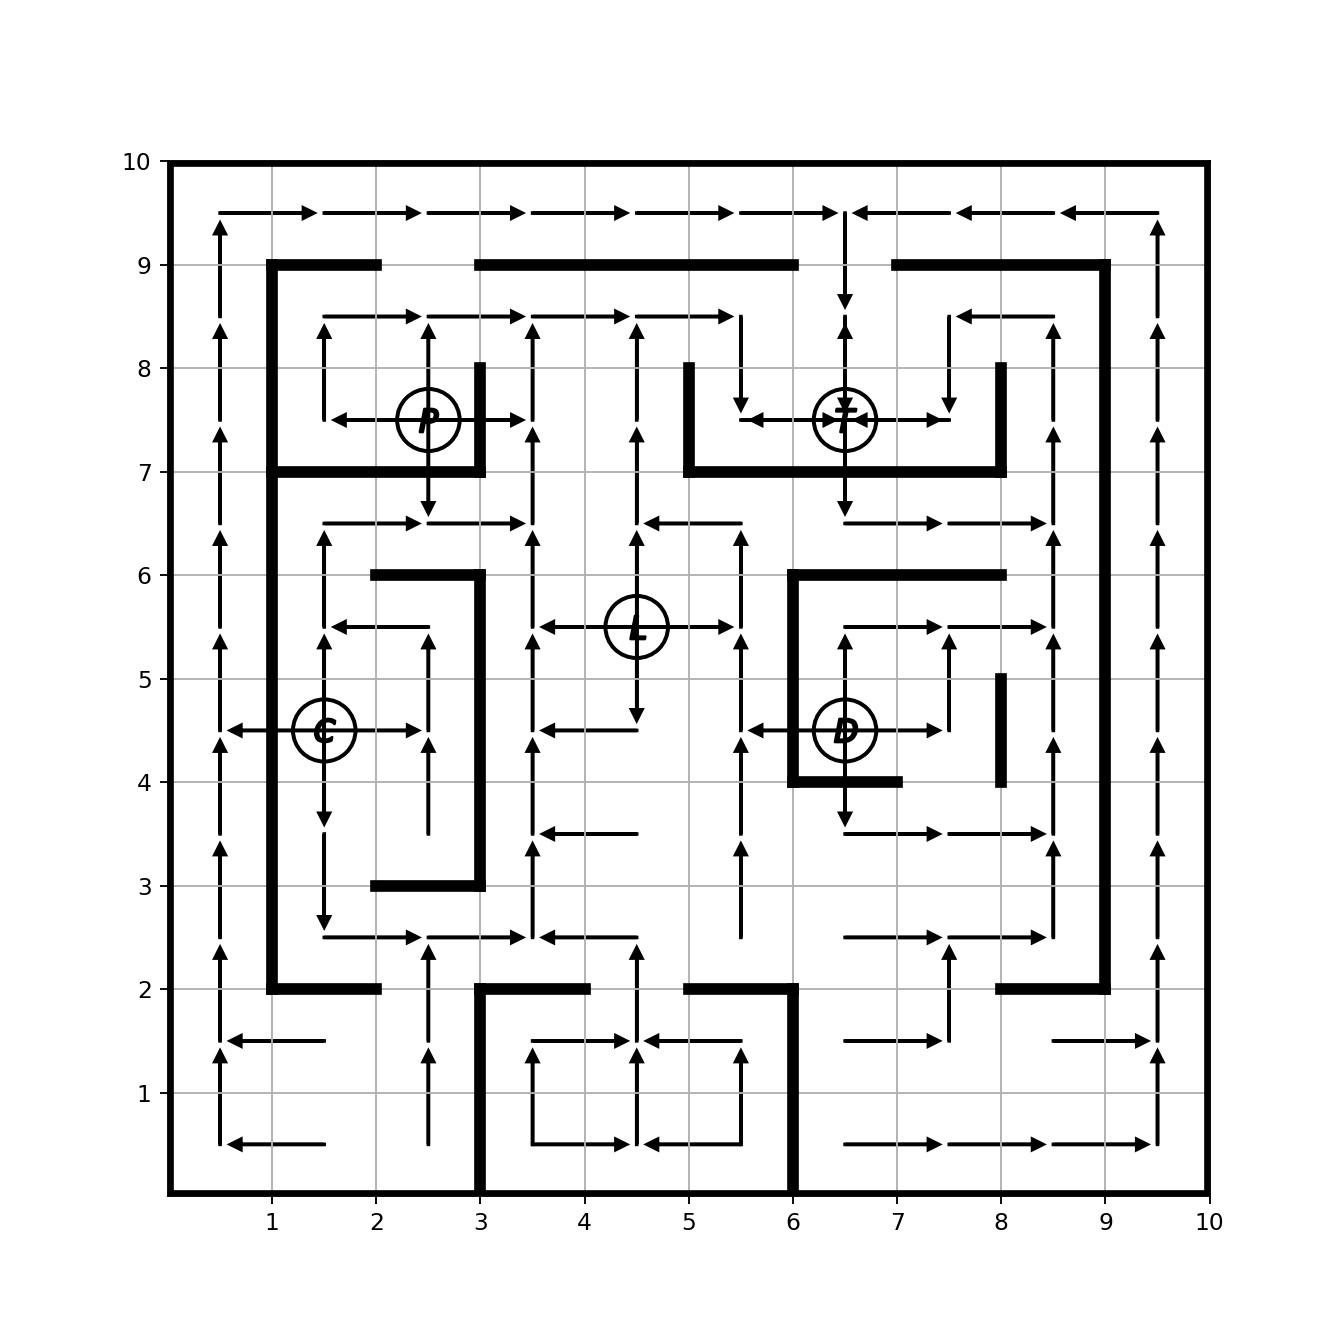

In [33]:
states = get_initial_states(X_w, objs_states)
for g in goals:
    print('Goal: ' + g)
    opt_mdp = mdps_w['mdp' + str(goals.index(g) + 1)]
    opt_pol, _ = opt_mdp.policy_iteration()
    leg_pol, _ = task_mdp_w.policy_iteration(goals.index(g))
    opt_figure = create_world_view(n_rows, n_cols, objs_states, walls)
    draw_policy_states(opt_figure, opt_pol, list(X_w), list(A_w), states, 'b')
    fig, _ = opt_figure
    fig.show()
    leg_figure = create_world_view(n_rows, n_cols, objs_states, walls)
    draw_policy_states(leg_figure, leg_pol, list(X_w), list(A_w), states, 'k')
    fig, _ = leg_figure
    fig.show()

In [36]:
states = get_initial_states(X_w, objs_states)

for g in goals:
    
    goal_idx = goals.index(g)
    opt_mdp = mdps_w['mdp' + str(goals.index(g) + 1)]
    leg_mdp = task_mdps_w['leg_mdp_' + str(goal_idx + 1)]
    
    opt_pol, _ = opt_mdp.policy_iteration()
    leg_pol, _ = leg_mdp.policy_iteration()
    
    opt_pol_cost = task_mdp_w.policy_cost(opt_pol, states)
    leg_pol_cost = task_mdp_w.policy_cost(leg_pol, states)    
    print(g, opt_pol_cost, leg_pol_cost)

N. iterations:  3
N. iterations:  10
P 0.20329713111668848 0.21900208772880536
N. iterations:  3
N. iterations:  6
D 0.18446723468788725 0.19633390517532287
N. iterations:  3
N. iterations:  7
C 0.17400828884863753 0.1782272634874747
N. iterations:  3
N. iterations:  8
L 0.18275733636679173 0.18626920907532044
N. iterations:  3
N. iterations:  8
T 0.23732293793040715 0.2593266740874447


N. iterations:  5
N. iterations:  7
N. iterations:  5
N. iterations:  7
N. iterations:  6
N. iterations:  6


<IPython.core.display.Javascript object>


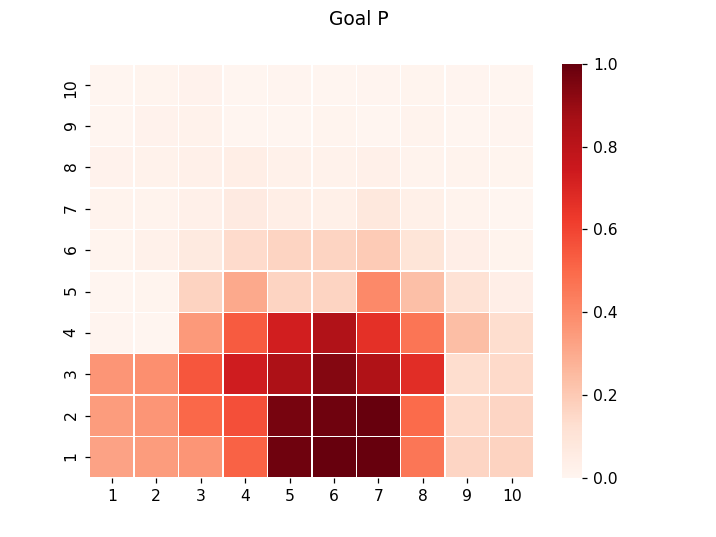

<IPython.core.display.Javascript object>


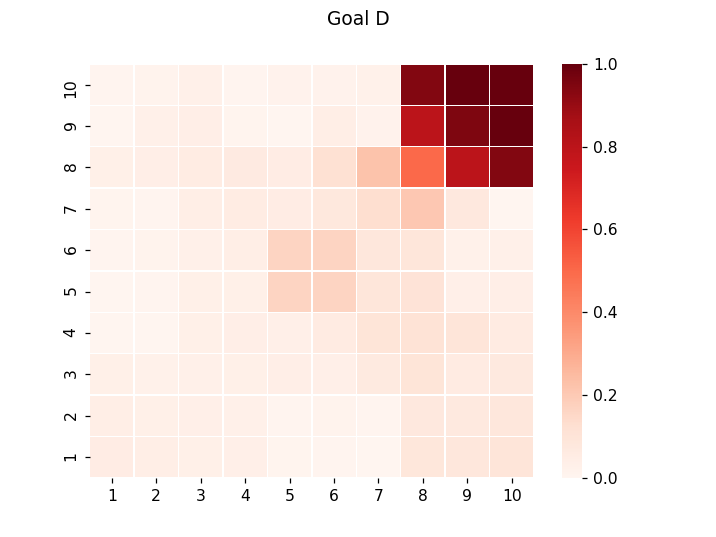

C:\Program Files\Python37\Lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


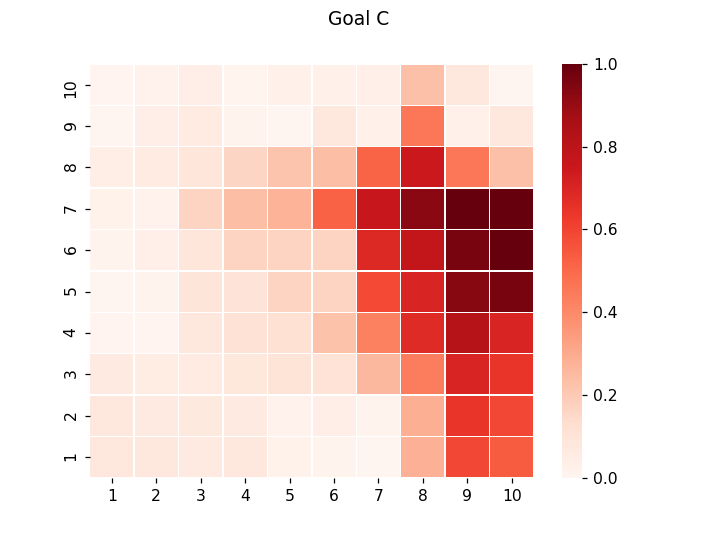

<IPython.core.display.Javascript object>


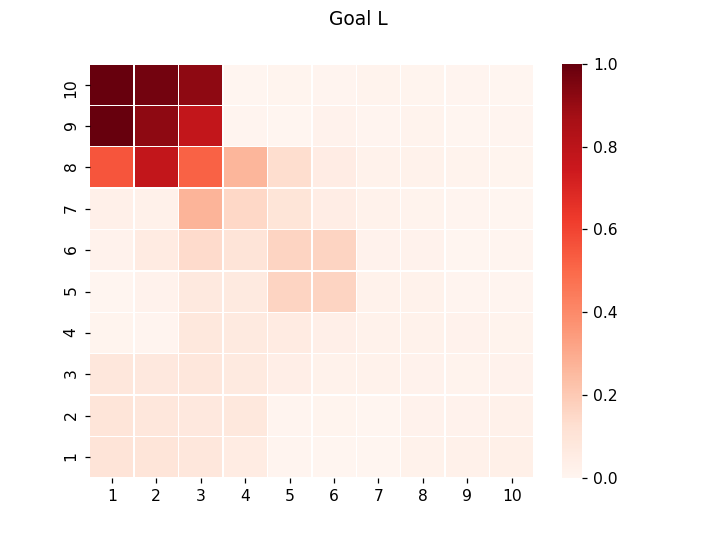

<IPython.core.display.Javascript object>


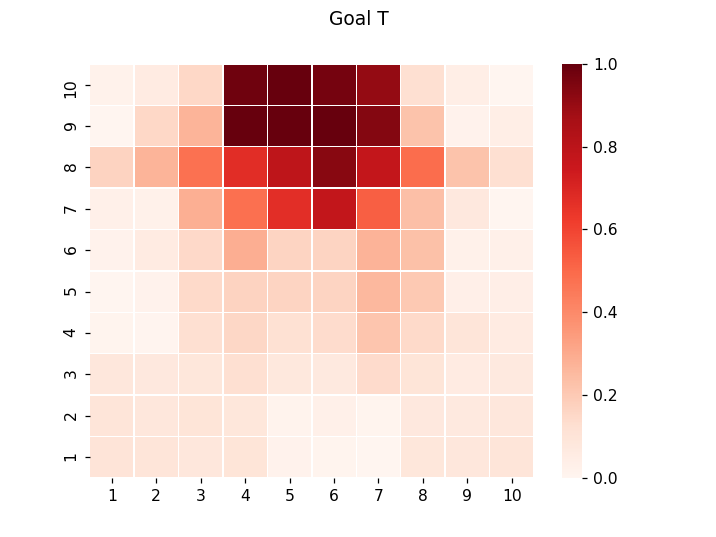

<IPython.core.display.Javascript object>


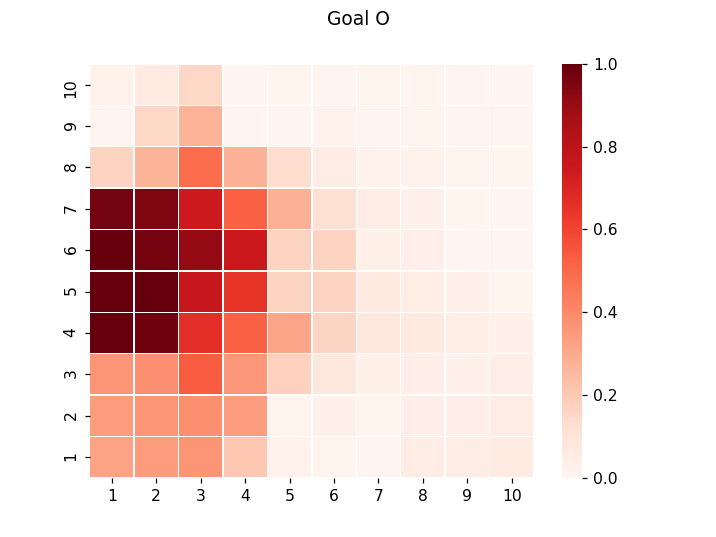

In [79]:
states = get_initial_states(X_w, objs_states)
n_tasks = len(goals)
legible_legibility = np.zeros((n_tasks, n_rows + 1, n_cols + 1))

for g in goals:
    
    goal_idx = goals.index(g)
    leg_mdp = task_mdps_w['leg_mdp_' + str(goal_idx + 1)]
    c = leg_mdp.costs
    pol, _ = leg_mdp.policy_iteration()
    
    for state in states:

        x = list(X_w).index(state)
        state_split = re.match(r"([0-9]+) ([0-9]+) ([a-zA-z]+)", state, re.I)
        x_row = int(state_split.group(1))
        x_col = int(state_split.group(2))
        x_act = np.nonzero(pol[x, :])[0]
        c_prob = c[x, :] / c[x, :].sum()
        nA = len(x_act)
        state_cost = 0

        for a in x_act:
            state_cost += c[x, a] / nA
        
        legible_legibility[goal_idx, x_row, x_col] = state_cost

for g in goals:

    goal_idx = goals.index(g)
    leg_min = math.floor(np.min(legible_legibility[goal_idx]))
    leg_max = math.ceil(np.max(legible_legibility[goal_idx]))

    fig, ax = plt.subplots()
    fig.suptitle('Goal ' + g)
    sns.heatmap(legible_legibility[goal_idx], cmap='Reds', vmin=leg_min, vmax=leg_max, linewidths=0.3, ax=ax)
    ax.set_xlim(1, n_cols + 1)
    ax.set_ylim(1, n_rows + 1)
    # ax.invert_yaxis()
    fig.show()

In [73]:
print('Creating demo trajectories')
n_trajs = 100
print('Optimal trajectories')
opt_trajs = []
opt_traj_len = 0
for _ in range(n_trajs):
    x0 = '1 1 N'
    t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
    opt_traj_len = max(opt_traj_len, len(t1))
    traj = []
    for i in range(len(t1)):
        traj += [[list(X_w).index(t1[i]), list(A_w).index(a1[i])]]
    opt_trajs += [np.array(traj)]
# print(opt_trajs)
print('Legible trajectories')
leg_trajs = []
leg_traj_len = 0
for _ in range(n_trajs):
    x0 = '1 1 N'
    traj = []
    task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
    leg_traj_len = max(leg_traj_len, len(task_traj))
    for i in range(len(task_traj)):
        traj += [[list(X_w).index(task_traj[i]), list(A_w).index(task_act[i])]]
    leg_trajs += [np.array(traj)]
# print(leg_trajs)

# for i in range(len(opt_trajs) - 1):
#     for j in range(i, len(opt_trajs)):
#         print((opt_trajs[i] == opt_trajs[j]).all(), end='\t')
#     print('\n')
    
# for i in range(len(leg_trajs) - 1):
#     for j in range(i, len(leg_trajs)):
#         print((leg_trajs[i] == leg_trajs[j]).all(), end='\t')
#     print('\n')

Creating demo trajectories
Optimal trajectories
Legible trajectories


In [78]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
# leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)


step = 1
print('Optimal trajectory eval')
# opt_learner_count, opt_avg_confidence = opt_learner.learner_eval(0.9, opt_trajs, opt_traj_len, step, goals.index(goal))
# leg_learner_count, leg_avg_confidence = leg_learner.learner_eval(0.9, opt_trajs, leg_traj_len, step, goals.index(goal))
# print(opt_learner_count/n_trajs, leg_learner_count/n_trajs)
# print(opt_avg_confidence, leg_avg_confidence)

print('Legible trajectory eval')
opt_learner_count, opt_avg_confidence = opt_learner.learner_eval(0.9, leg_trajs, opt_traj_len, step, goals.index(goal))
# leg_learner_count, leg_avg_confidence = leg_learner.learner_eval(0.9, leg_trajs, leg_traj_len, step, goals.index(goal))
# print(opt_learner_count/n_trajs, leg_learner_count/n_trajs)
# print(opt_avg_confidence, leg_avg_confidence)

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  11
N. iterations:  8
N. iterations:  9
N. iterations:  10
N. iterations:  8
N. iterations:  8
Optimal trajectory eval
Legible trajectory eval
1 1 N R
[0.19908073 0.1988844  0.19897416 0.19897416 0.19889405 0.19889405]
1 2 N R
[0.03955173 0.0394563  0.03949992 0.03949992 0.03946099 0.03946099]
1 3 N D
[0.00783719 0.00780273 0.00781847 0.00781847 0.00780442 0.00780442]
2 3 N D
[0.00154839 0.00153755 0.0015425  0.0015425  0.00153808 0.00153808]
3 3 N R
[0.00031175 0.00031074 0.00031148 0.00031148 0.00031082 0.00031082]
3 4 N R
[6.20137166e-05 6.30398716e-05 6.24354247e-05 6.24354247e-05
 6.26802564e-05 6.26802564e-05]
3 5 N R
[1.22781393e-05 1.25766876e-05 1.23840855e-05 1.23815444e-05
 1.24646271e-05 1.24646271e-05]
3 6 N R
[2.42179861e-06 2.53897113e-06 2.44328274e-06 2.44064415e-06
 2.45390740e-06 2.45981474e-06]
3 7 N R
[4.88359591e-07 5.043729

In [16]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_trajs = []
for i in range(len(trajs)):
    p_traj = []
    traj = trajs[i]
    a_traj = a_trajs[i]
    for j in range(len(traj)):
        p_traj += [[list(X_w).index(traj[j]), list(A_w).index(a_traj[j])]]
    p_trajs +=  [np.array(p_traj)]

p_leg_trajs = []
for i in range(len(leg_trajs)):
    p_traj = []
    traj = leg_trajs[i]
    a_traj = leg_a_trajs[i]
    for j in range(len(traj)):
        p_traj += [[list(X_w).index(traj[j]), list(A_w).index(a_traj[j])]]
    p_leg_trajs +=  [np.array(p_traj)]
    
print('Learning')
indexes = []
traj_len = len(p_trajs[0])
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
#for traj in p_trajs:
for traj in p_leg_trajs:
    for i in range(n_idx):
        idx = indexes[i]
        r, o_idx = opt_learner.birl_inference(traj[:idx], 0.9)
        r, l_idx = leg_learner.birl_inference(traj[:idx], 0.9)
        print(o_idx, l_idx, goals.index(goal))

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  9
N. iterations:  10
N. iterations:  9
N. iterations:  11
N. iterations:  9
N. iterations:  11
N. iterations:  7
N. iterations:  6
N. iterations:  6
N. iterations:  6
N. iterations:  7
N. iterations:  7
Preparing Trajectories
Learning
[[0.20256820395118674, 0.20301073265900071, 0.20163574553769653, 0.203049314997532, 0.20269176442114917, 0.2029794840170114], [0.19849996631854322, 0.19824297652607725, 0.19854573103445547, 0.19822059108847415, 0.1984281674727827, 0.1982611093662127]]
[[0.11996787179347485, 0.2837385303607539, 0.14804434416818826, 0.12663912325137214, 0.251933764108495, 0.23820341896092703], [0.25450842881558733, 0.3370266544005124, 0.2236689237677673, 0.24774715199644676, 0.2936209464330597, 0.27100038443782576]]
1 1 4
[[0.20256820395118674, 0.20301073265900071, 0.20163574553769653, 0.203049314997532, 0.20269176442114917, 0.202979

<IPython.core.display.Javascript object>


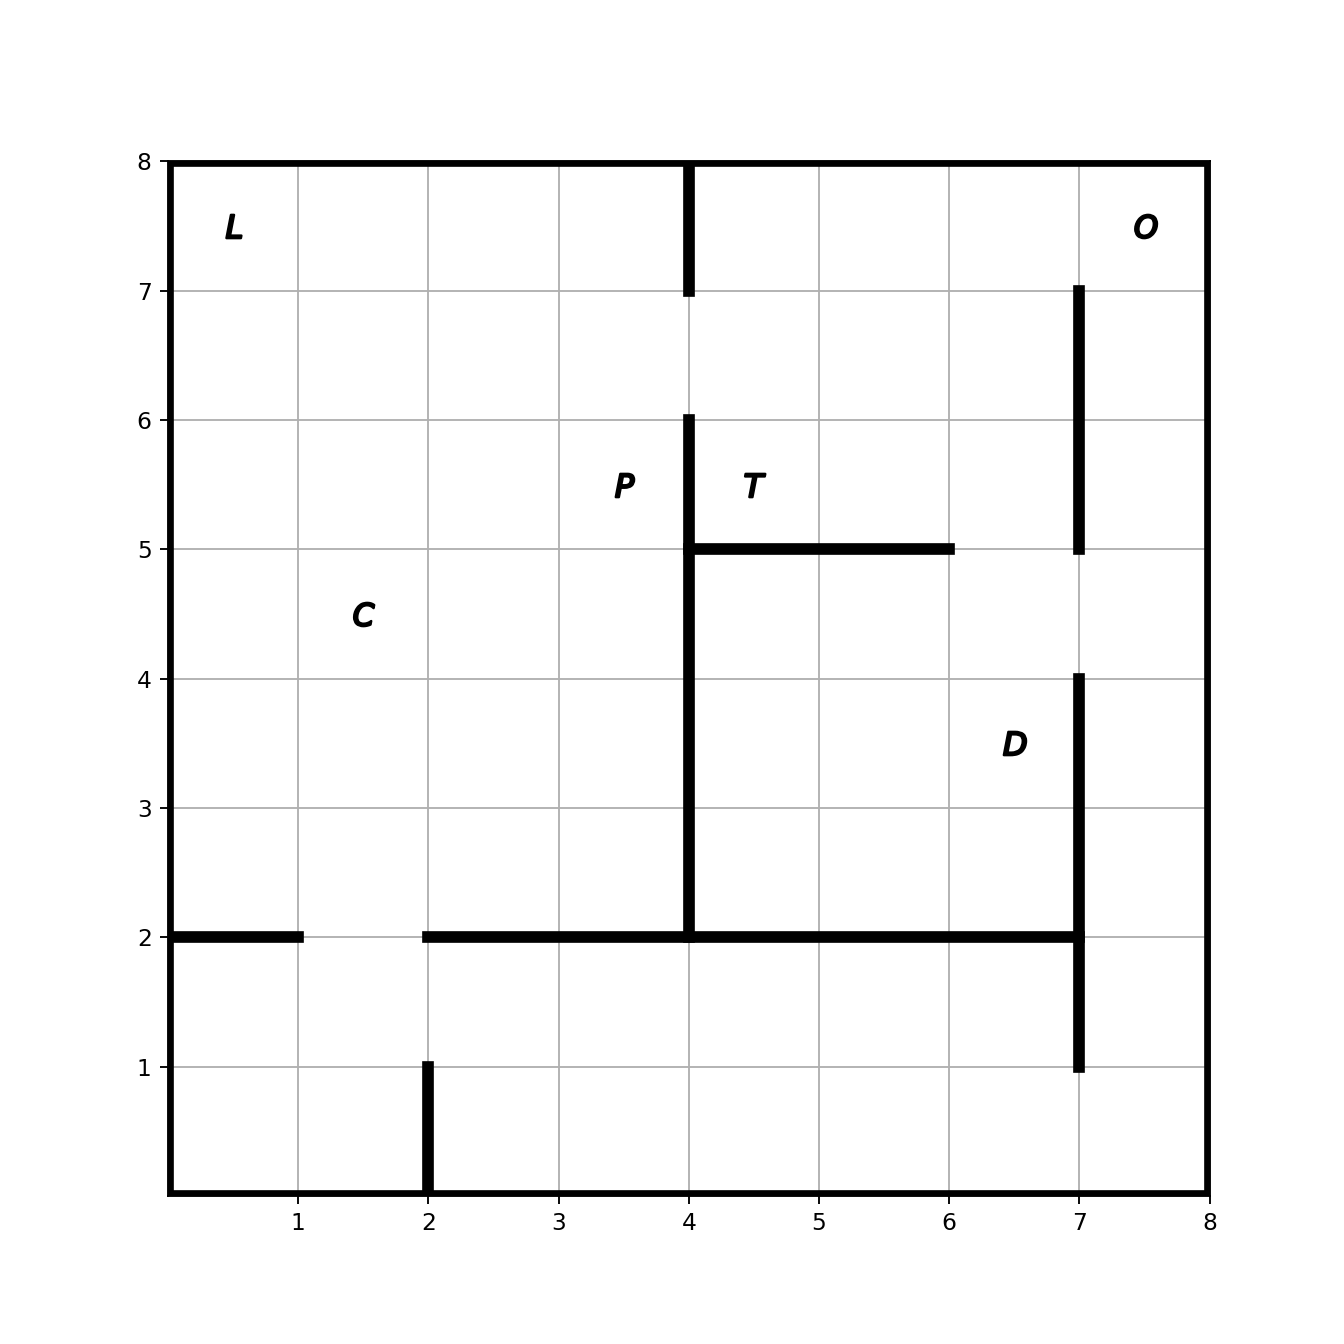

In [9]:
def irl_trajectory(mdp, goal, pol, x0):
    X = mdp[0]
    A = mdp[1]
    P = mdp[2]

    nX = len(X)
    nA = len(A)

    traj = [x0]
    actions = []
    x = list(X).index(x0)
    stop = False

    print(x0)
    while not stop:
        a = np.random.choice(nA, p=pol[x, :])
        x = np.random.choice(nX, p=P[A[a]][x, :])

        print(A[a], X[x])
        
        traj += [X[x]]
        actions += [A[a]]

        stop = (X[x].find(goal) != -1)
        if stop:
            actions += [A[np.random.choice(nA, p=pol[x, :])]]

    return np.array(traj), np.array(actions)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

<IPython.core.display.Javascript object>


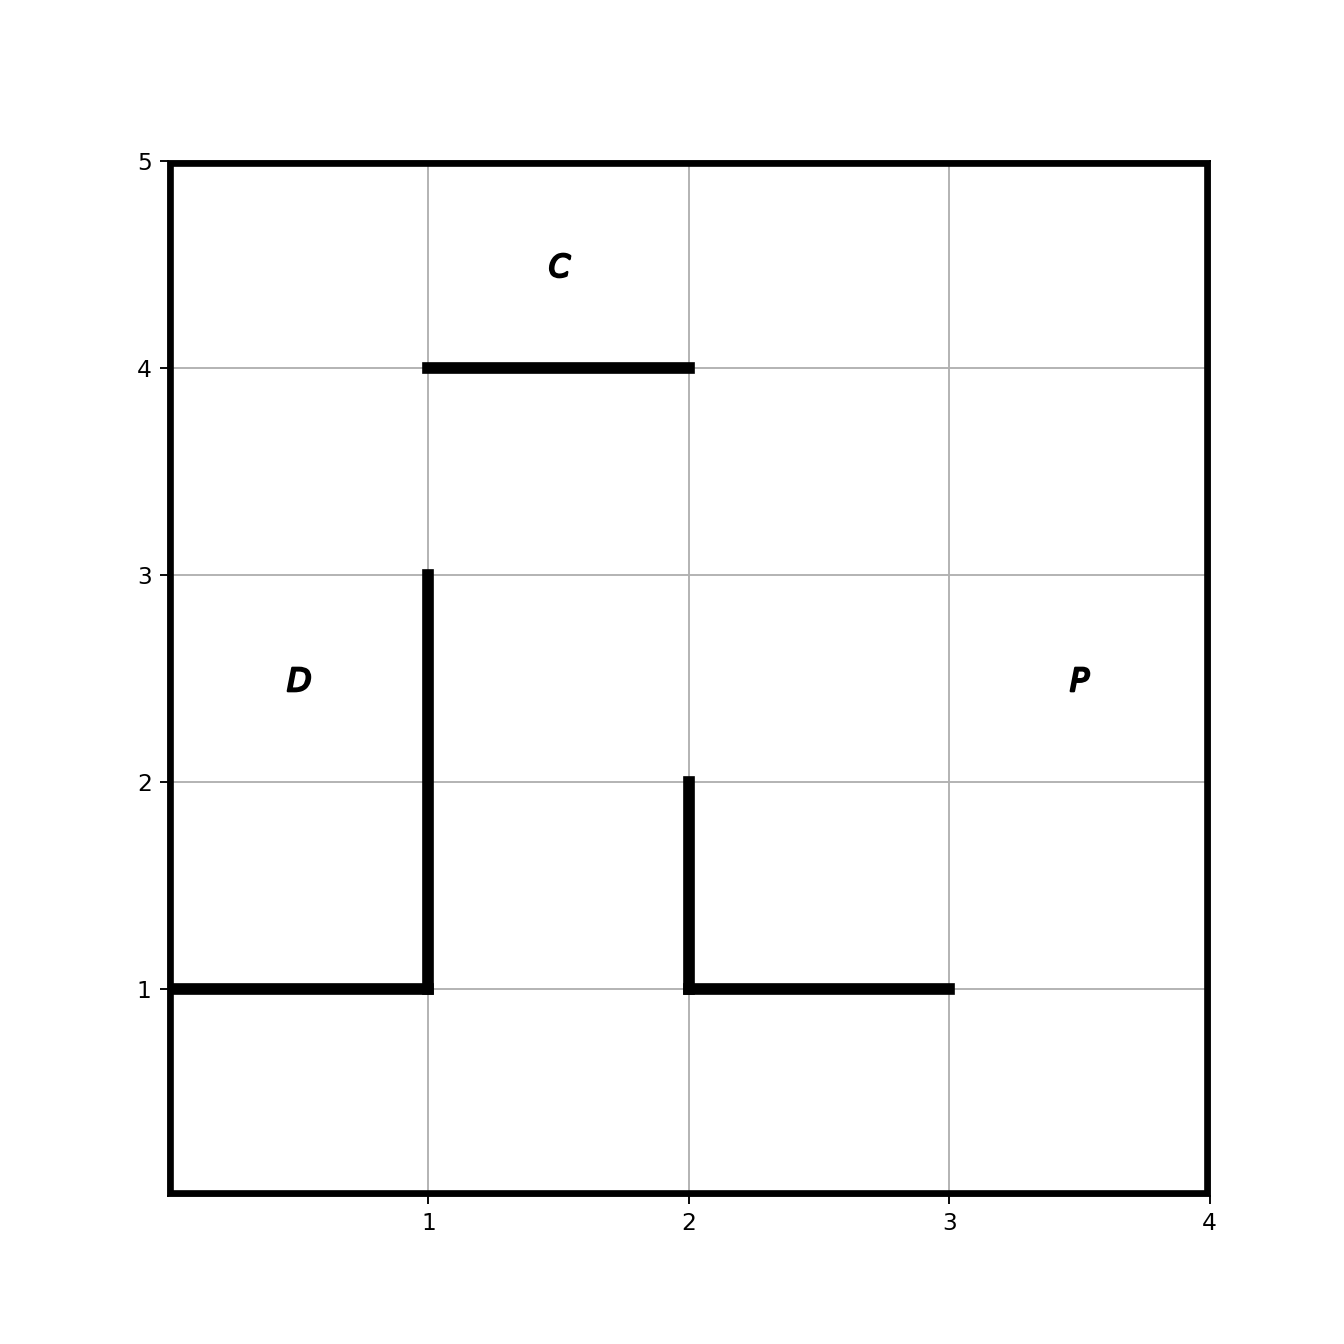

In [47]:
n_rows = 5
n_cols = 4
objs_states = [(3, 4, 'P'), (3, 1, 'D'), (5, 2, 'C')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(1.5, x + 0.5) for x in range(0, 2)],
         [(1.5, x + 0.5) for x in range(2, 4)],
         [(4.5, x + 0.5) for x in range(1, 3)],
         [(x + 0.5, 1.5) for x in range(1, 4)],
         [(x + 0.5, 2.5) for x in range(1, 3)],
        ]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D', 'C']
goal = 'P'

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [50]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
wacmw = WallAutoCollectMazeWorld()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls, 'stochastic', 0.15)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
q_mdps_w = []
task_mdps_w = {}
costs = []
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = wacmw.generate_costs(goals[i], X_w, A_w)
    costs += [c]
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]))
    _, q = mdp.policy_iteration()
    q_mdps_w += [q]
    mdps_w['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
leg_costs = []
for i in tqdm(range(len(goals)), desc='Legible Task MDPs'):
    mdp = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[i], objs_states, goals, 0.5, get_goal_states(X_w, goals[i]), 
                         -1, 'leg_optimal',
                         # task_mdps=list(mdps_w.values()))
                         q_mdps=q_mdps_w)
    leg_costs += [mdp.costs]
    task_mdps_w['leg_mdp_' + str(i + 1)] = mdp
task_mdp_w = task_mdps_w['leg_mdp_' + str(goals.index(goal) + 1)]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))


Single Task MDPs:   0%|                                                                          | 0/3 [00:00<?, ?it/s]

##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
### Computing Costs and Creating Task MDPs ###



Single Task MDPs:  33%|██████████████████████                                            | 1/3 [00:00<00:00,  2.81it/s]

N. iterations:  3



Single Task MDPs:  67%|████████████████████████████████████████████                      | 2/3 [00:00<00:00,  3.06it/s]

N. iterations:  3



Single Task MDPs: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.97it/s]

Legible Task MDPs:  33%|█████████████████████▋                                           | 1/3 [00:00<00:00,  9.62it/s]

N. iterations:  3
Legible task MDP
P 1 1 N [0.4267934  0.4267934  0.4267934  0.43741752 0.4267934 ]
P 1 1 P [0.90639481 0.90639481 0.90639481 0.8852554  0.90639481]
P 1 1 D [0.06852415 0.06852415 0.06852415 0.08712832 0.06852415]
P 1 1 C [0.06775207 0.06775207 0.06775207 0.08580699 0.06775207]
P 1 1 PD [0.48893964 0.48893964 0.48893964 0.48640428 0.48893964]
P 1 1 PC [0.48590162 0.48590162 0.48590162 0.48222645 0.48590162]
P 1 1 DC [0.03702327 0.03702327 0.03702327 0.04797258 0.03702327]
P 1 1 PDC [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
P 1 2 N [0.43929382 0.45132077 0.42866698 0.57177739 0.43929382]
P 1 2 P [0.88111693 0.85143021 0.90293808 0.90293808 0.88111693]
P 1 2 D [0.09083458 0.11791519 0.07152537 0.12056481 0.09083458]
P 1 2 C [0.08938568 0.1153504  0.07067493 0.11920615 0.08938568]
P 1 2 PD [0.48590162 0.48222645 0.48852851 0.48852851 0.48590162]
P 1 2 PC [0.48148836 0.47601371 0.48531151 0.48531151 0.48148836]
P 1 2 DC [0.05020051 0.06696044 0.0387634  0.066


Legible Task MDPs:  67%|███████████████████████████████████████████▎                     | 2/3 [00:00<00:00,  8.11it/s]

D 3 3 D [0.73779239 0.68591092 0.73779239 0.59788223 0.6613739 ]
D 3 3 C [0.06089434 0.10345709 0.10345709 0.04912926 0.07209536]
D 3 3 PD [0.47358118 0.45165266 0.47358118 0.47358118 0.46479364]
D 3 3 PC [0.0387634  0.06696044 0.06696044 0.0387634  0.05020051]
D 3 3 DC [0.44566766 0.44566766 0.44566766 0.3904725  0.42363698]
D 3 3 PDC [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
D 3 4 P [0.05304326 0.08099243 0.08099243 0.06502057 0.06502057]
D 3 4 PD [0.4806183  0.46651978 0.46651978 0.47489974 0.47489974]
D 3 4 PC [0.02937697 0.04797258 0.04797258 0.03702327 0.03702327]
D 3 4 PDC [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
D 4 1 N [0.69890861 0.36890098 0.51963085 0.44462432 0.51963085]
D 4 1 P [0.32577884 0.15429046 0.22701148 0.17355891 0.22701148]
D 4 1 D [0.80536049 0.70565466 0.75003426 0.76654278 0.75003426]
D 4 1 C [0.34172862 0.18409103 0.24587837 0.17574754 0.24587837]
D 4 1 PD [0.46274299 0.42799597 0.44892072 0.46274299 0.44892072]
D 4 1 PC [0.219


Legible Task MDPs: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  5.60it/s]

 [0.4806183  0.4806183  0.47489974 0.46651978 0.47489974]
C 4 1 PDC [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
C 4 2 N [0.22924417 0.28553864 0.32333565 0.36335329 0.28553864]
C 4 2 P [0.0876714  0.10985218 0.1380731  0.15568909 0.10985218]
C 4 2 D [0.08416206 0.1162657  0.16149738 0.14990447 0.1162657 ]
C 4 2 C [0.72721054 0.72513304 0.6905882  0.72721054 0.72513304]
C 4 2 PD [0.05283763 0.07041273 0.09669468 0.09669468 0.07041273]
C 4 2 PC [0.46274299 0.44892072 0.42799597 0.46274299 0.44892072]
C 4 2 DC [0.45165266 0.46479364 0.47358118 0.45165266 0.46479364]
C 4 2 PDC [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
C 4 3 N [0.26438238 0.5524354  0.3003422  0.26438238 0.37513442]
C 4 3 P [0.12653398 0.23236262 0.11710037 0.12653398 0.16501478]
C 4 3 D [0.10753059 0.2246886  0.1218005  0.10753059 0.15638801]
C 4 3 C [0.6905882  0.78579462 0.72721054 0.6905882  0.72513304]
C 4 3 PD [0.07451401 0.14400806 0.07451401 0.07451401 0.10215857]
C 4 3 PC [0.47358118 0.4

N. iterations:  3
Took 0.354 seconds to compute policy
### Computing Legible policy ###
N. iterations:  5
Took 0.514 seconds to compute policy



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it

Initial State: 1 1 N
##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
Optimal trajectory for task: P
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '3 2 N' '3 3 P']
Cost: 3.439
Legible Reward: 2.740099999992011
Legible trajectory for task: P
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '2 3 N' '2 3 N' '2 3 N' '2 3 N' '2 3 N' '3 3 P']
Cost: 5.6953279000000006
Legible Reward: 5.175795109830954
[0. 0. 0. 1. 0.]
[0.5 0.5 0.5 0.5 0.5]
[0. 1. 0. 0. 0.]
[0.5 0.5 0.5 0.5 0.5]
[0. 0. 0. 1. 0.]
[5.00000000e-01 5.00000000e-01 1.75586958e-10 1.00000000e+00
 5.00000000e-01]
[0.25 0.25 0.   0.25 0.25]
[1.         1.         0.92385223 1.         1.        ]
[0.25 0.25 0.   0.25 0.25]
[1.         1.         0.92385223 1.         1.        ]
[0.25 0.25 0.   0.25 0.25]
[1.         1.         0.92385223 1.         1.        ]
[0.25 0.25 0.   0.25 0.25]
[1.         1.         0.92385223 1.         1.        ]
[0.25 0.25 0.   0.25 0.25]
[1.    

<IPython.core.display.Javascript object>


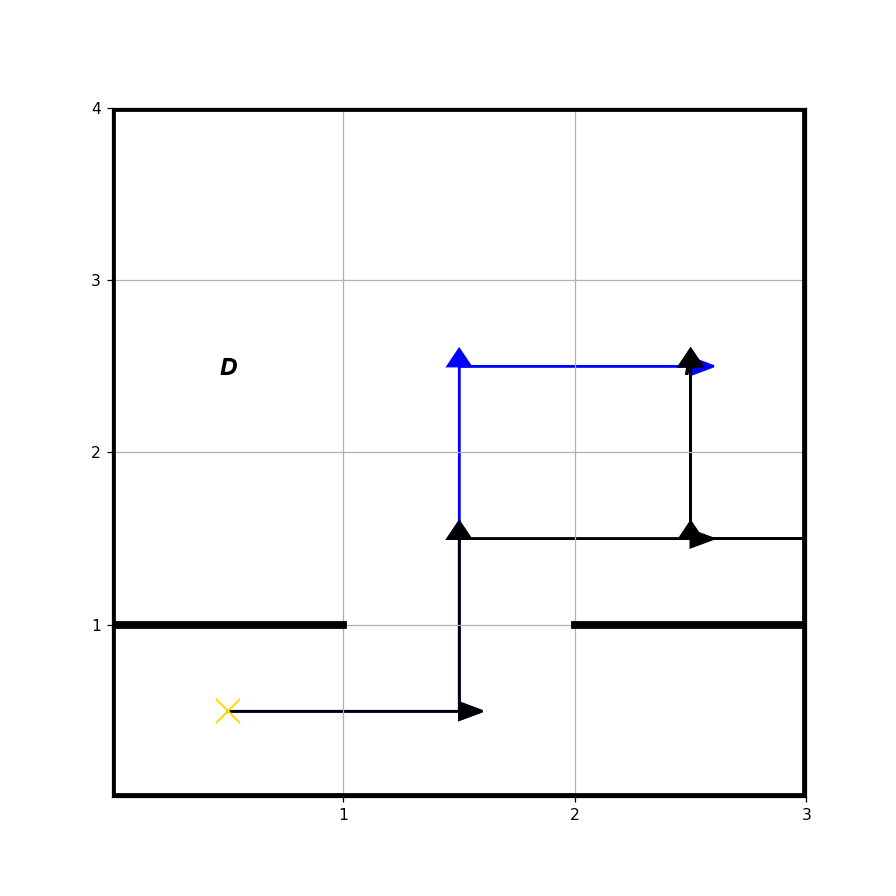


Simulate Trajectories:  10%|██████████████████▏                                                                                                                                                                       | 98/1000 [00:00<00:00, 970.37it/s]

Getting model performance!!



Simulate Trajectories: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1047.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 66516.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 66488.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 45417.97it

Simulation length = 1.050
Optimal Policy performance:
Cost: 3.744
Legible Reward: 3.106
legible Policy performance:
Cost: 5.221
Legible Reward: 4.655


In [221]:
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

for ptr in task_traj:
    print(task_pol_w[list(X_w).index(ptr)])
    print(leg_costs[goals.index(goal)][list(X_w).index(ptr)])

fig = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
                                                task_mdp_w, task_pol_w, x0, 1000)
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

In [23]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.67it/s]

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  4
N. iterations:  4
N. iterations:  3
N. iterations:  3
Preparing Trajectories
Learning
1 0 1
0 1 1
1 1 1
1 1 1


In [38]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1346.05it/s]

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  4
N. iterations:  4
N. iterations:  3
N. iterations:  3
Preparing Trajectories
Learning
0 1 1
0 1 1
1 1 1
1 1 1


<IPython.core.display.Javascript object>


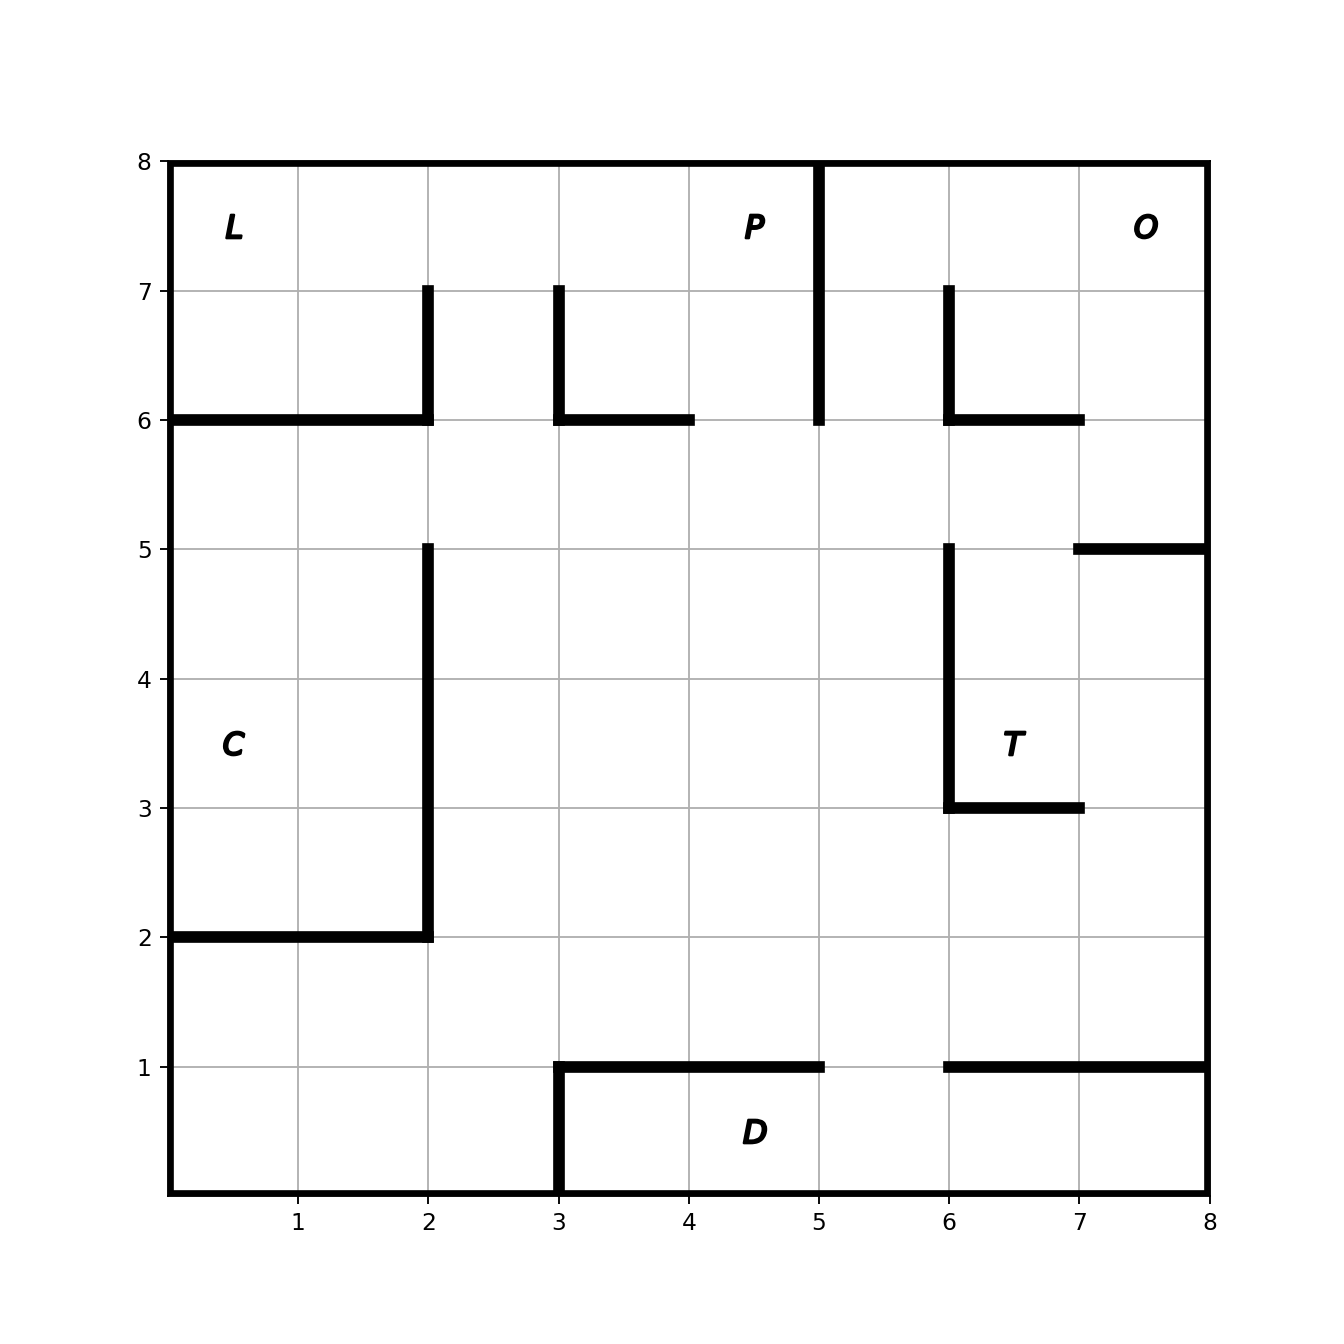

In [36]:
n_rows = 8
n_cols = 8
objs_states = [(8, 5, 'P'), (1, 5, 'D'), (4, 1, 'C'), (8, 1, 'L'), (4, 7, 'T'), (8, 8, 'O')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(x + 0.5, 2.5) for x in range(2, 6)],
         [(x + 0.5, 2.5) for x in range(6, 8)],
         [(x + 0.5, 3.5) for x in range(0, 2)],
         [(x + 0.5, 3.5) for x in range(6, 8)],
         [(x + 0.5, 5.5) for x in range(6, 9)],
         [(x + 0.5, 6.5) for x in range(3, 6)],
         [(x + 0.5, 6.5) for x in range(6, 8)],
         [(2.5, x + 0.5) for x in range(0, 3)],
         [(1.5, x + 0.5) for x in range(3, 6)],
         [(1.5, x + 0.5) for x in range(6, 9)],
         [(3.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(0, 3)],
         [(6.5, x + 0.5) for x in range(3, 5)],
         [(6.5, x + 0.5) for x in range(6, 8)],
         [(5.5, x + 0.5) for x in range(7, 9)]
        ]

fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()
print(np.array(walls, dtype=object))

<IPython.core.display.Javascript object>


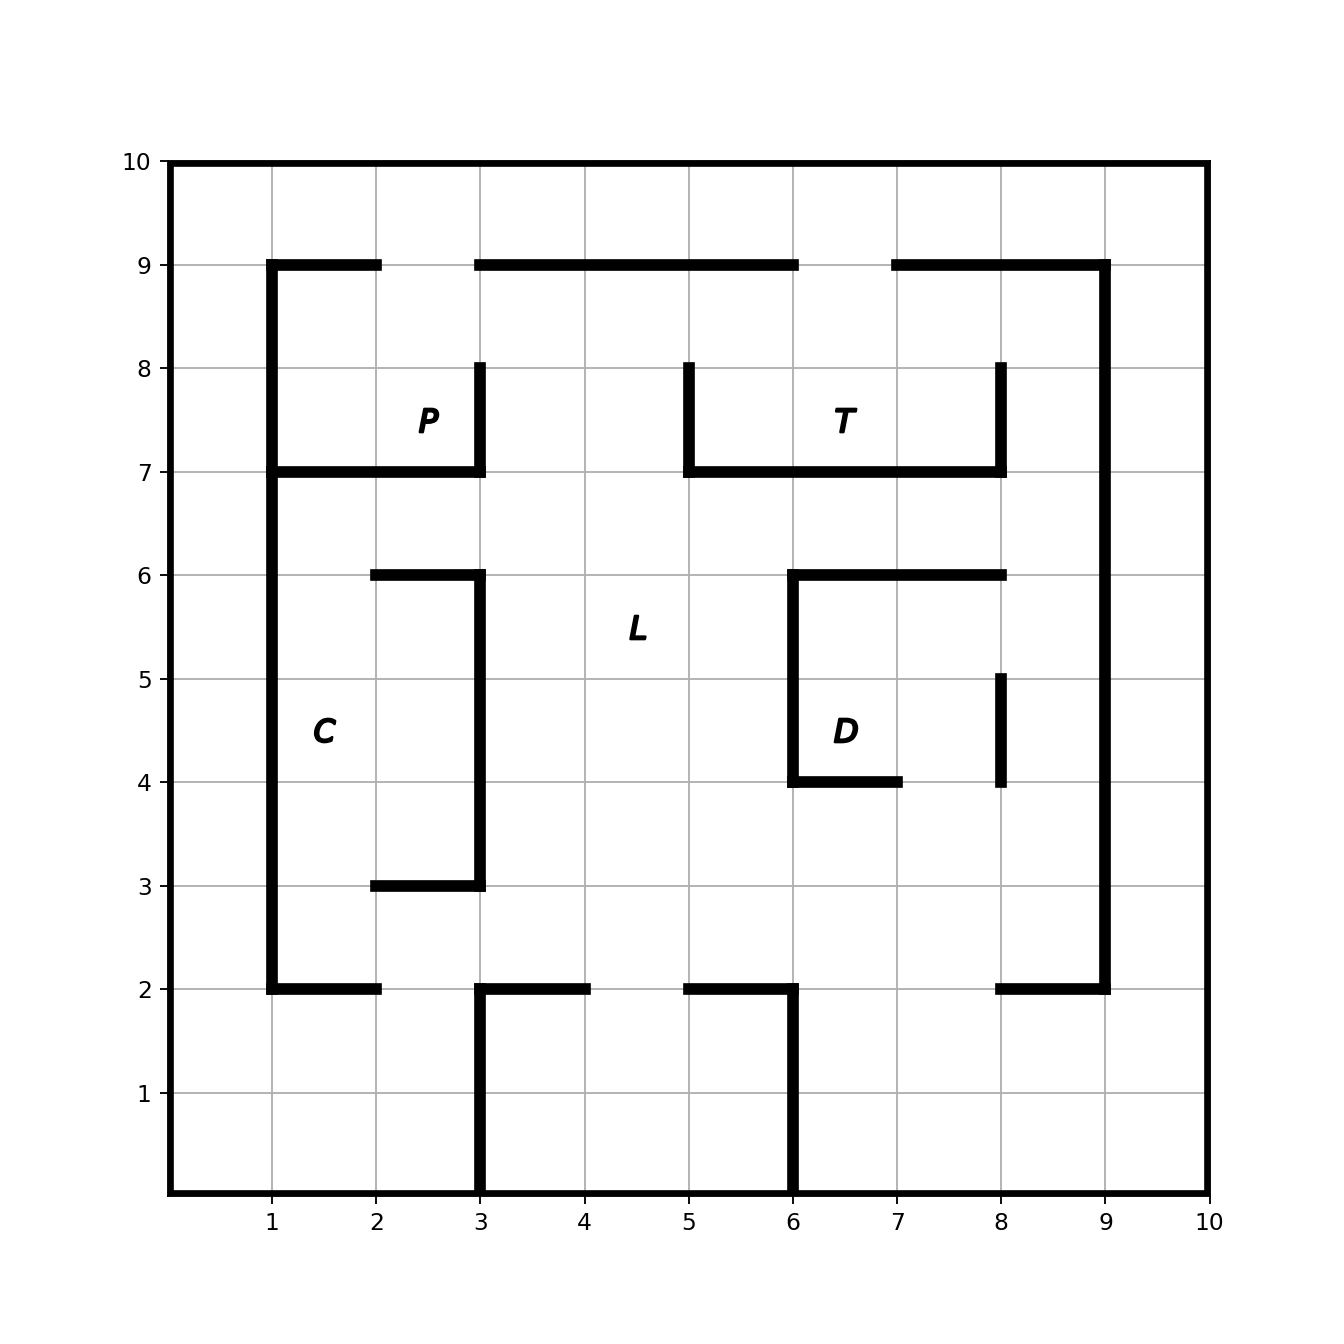

[list([(0.5, 0.5), (0.5, 1.5), (0.5, 2.5), (0.5, 3.5), (0.5, 4.5), (0.5, 5.5), (0.5, 6.5), (0.5, 7.5), (0.5, 8.5), (0.5, 9.5), (0.5, 10.5)])
 list([(10.5, 0.5), (10.5, 1.5), (10.5, 2.5), (10.5, 3.5), (10.5, 4.5), (10.5, 5.5), (10.5, 6.5), (10.5, 7.5), (10.5, 8.5), (10.5, 9.5), (10.5, 10.5)])
 list([(0.5, 0.5), (1.5, 0.5), (2.5, 0.5), (3.5, 0.5), (4.5, 0.5), (5.5, 0.5), (6.5, 0.5), (7.5, 0.5), (8.5, 0.5), (9.5, 0.5), (10.5, 0.5)])
 list([(0.5, 10.5), (1.5, 10.5), (2.5, 10.5), (3.5, 10.5), (4.5, 10.5), (5.5, 10.5), (6.5, 10.5), (7.5, 10.5), (8.5, 10.5), (9.5, 10.5), (10.5, 10.5)])
 list([(2.5, 1.5), (3.5, 1.5), (4.5, 1.5), (5.5, 1.5), (6.5, 1.5), (7.5, 1.5), (8.5, 1.5), (9.5, 1.5)])
 list([(0.5, 3.5), (1.5, 3.5), (2.5, 3.5)])
 list([(3.5, 3.5), (4.5, 3.5), (5.5, 3.5), (6.5, 3.5)])
 list([(7.5, 3.5), (8.5, 3.5)]) list([(7.5, 5.5), (8.5, 5.5)])
 list([(0.5, 6.5), (1.5, 6.5), (2.5, 6.5)])
 list([(4.5, 6.5), (5.5, 6.5), (6.5, 6.5)]) list([(4.5, 8.5), (5.5, 8.5)])
 list([(7.5, 8.5), (8.5, 8.5

In [15]:
n_rows = 10
n_cols = 10
objs_states = [(8, 3, 'P'), (5, 7, 'D'), (5, 2, 'C'), (6, 5, 'L'), (8, 7, 'T')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, 1.5) for x in range(2, 10)],
         [(x + 0.5, 3.5) for x in range(0, 3)],
         [(x + 0.5, 3.5) for x in range(3, 7)],
         [(x + 0.5, 3.5) for x in range(7, 9)],
         [(x + 0.5, 5.5) for x in range(7, 9)],
         [(x + 0.5, 6.5) for x in range(0, 3)],
         [(x + 0.5, 6.5) for x in range(4, 7)],
         [(x + 0.5, 8.5) for x in range(4, 6)],
         [(x + 0.5, 8.5) for x in range(7, 9)],
         [(x + 0.5, 9.5) for x in range(2, 10)],
         [(2.5, x + 0.5) for x in range(1, 3)],
         [(2.5, x + 0.5) for x in range(3, 5)],
         [(2.5, x + 0.5) for x in range(5, 7)],
         [(2.5, x + 0.5) for x in range(8, 10)],
         [(3.5, x + 0.5) for x in range(2, 4)],
         [(4.5, x + 0.5) for x in range(6, 8)],
         [(6.5, x + 0.5) for x in range(2, 4)],
         [(6.5, x + 0.5) for x in range(6, 9)],
         [(7.5, x + 0.5) for x in range(1, 4)],
         [(7.5, x + 0.5) for x in range(5, 9)],
         [(9.5, x + 0.5) for x in range(1, 3)],
         [(9.5, x + 0.5) for x in range(3, 7)],
         [(9.5, x + 0.5) for x in range(7, 10)]
        ]

fig, _ = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()
print(np.array(walls, dtype=object))